## State Farm Classification 
<a id="top"></a>
by Steve Bramhall
<br>txbramhall@verizon.net
<br>972-351-1230

###  Introduction

This case study pertains to building two models from anonymous data. The work was performed using Python in a Jupyter Notebook for readability. The steps for data cleaning included correcting misspelled words, creating common abbreviations of categorical data, and imputing missing data. Opportunities to reduce features were explored and transformed data sets were created using scaled continuous data, one-hot encoding the categorical data, and creating a Principal Components Analysis (PCA) data set. 

The analysis leads to a binary classification problem. First, the data was split into an 80/20 train/test split. A logistic regression model was selected as a baseline model and a random forest model improves upon the logistic regression. The modeling process included a starting baseline with default settings. Then, executing grid searches to find the optimal hyperparameters. Finally, the models were executed with the best parameters.

### Results

|Model|AUC|
|-|-|
| Logistic Regression | 0.91 |
| Random Forest | 0.97 |



### Recommendation
Two classification models were tuned for optimal performance using an 80/20 split of the train data file where training and tuning the model occurred on the 80% split and validation was performed on the 20% split. The logistic regression model produced an AUC of 0.91 and the random forest model produced an AUC of 0.97. Training and tuning the logistic regression model occurred much faster than the random forest model but the recommended model is the random forest model. The random forest model is recommended not only for its results but also because this data set exhibits characteristics in which random forest (decision tree) models are robust as described in the Modeling section.

### Table of Contents

* <a href="#ReadData">Read Data</a>
* <a href="#InitObs">Initial Observations</a>
* <a href="#CatObs">Categorical Features Observations</a>
* <a href="#NumObs">Numeric Features Observations</a>
* <a href="#CheckNulls">Review Missing Data</a>
* <a href="#Impute">Imputation</a>
* <a href="#LabelBal">Check Label Balance</a>
* <a href="#CatPlots">Review Categorical Data by Label Class</a>
* <a href="#FR">Feature Reduction</a>
* <a href="#DataTrans">Data Transformation</a>
    * <a href="#PCA">PCA Analysis</a>
* <a href="#Modeling">Modeling</a>
    * <a href="#LogReg">Logistic Regression</a>
    * <a href="#rf">Random Forest</a>

### <i>Libraries</i>

Python libraries used in this notebook. 

In [1]:
# for showing all print statements in a cell, not just the last print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import pandas as pd

# for showing up to 500 rows/columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# used to check for string data type
from pandas.api.types import is_string_dtype
import numpy as np

# for using regular expressions
import re 

import matplotlib.pyplot as plt
%matplotlib inline

# utility
import seaborn as sns
from datetime import datetime as DT, timedelta
import string

# for viewing missing data
import missingno as msno 

# data processing
import sklearn.preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

# modeling
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn import feature_selection

# for visualizations, compatible with sklearn
import yellowbrick as yb
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import AlphaSelection
from yellowbrick.features import RFECV
from yellowbrick.classifier import ClassificationReport, ROCAUC, ClassBalance

C:\Users\Steve\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### <i>Functions</i>
These functions define repeatable processes used in this notebook. 

In [2]:
# The function uses a chunking technique to read large files
def ReadFile(file_path, chunksize=100000, low_memory=False):
    df = pd.read_csv(file_path, chunksize=chunksize, low_memory=low_memory)

    chunk_list = []  # append each chunk df here 

    for x in df:
        chunk_list.append(x)

    return pd.concat(chunk_list)

# This function accepts a dataframe and provide the column & row count.
# And by variable - Unique Count, Data Type, Missing Count, Duplicate Count
def GetDataInfo(dataframe):
    print (f'Data Frame Columns = {dataframe.shape[1]}\nData Frame Rows = {dataframe.shape[0]}\n')

    var_info = pd.DataFrame(columns=['Uniques','Type','Missing', 'Missing %','Duplicates']) # create empty DF with col names

    row_cnt = len(dataframe)
    for col, cnt in dataframe.nunique().to_dict().items():
        if (is_string_dtype(dataframe[col])):
            dtype = 'categorical' 
        else: 
            dtype = 'numeric'
    
        missing = dataframe[col].isnull().sum() # get NaN counts
        missing_percent = 100*missing/row_cnt
        duplicates = len(dataframe[col])-len(dataframe[col].drop_duplicates())

        var_info.loc[col] = [cnt, dtype, missing, missing_percent, duplicates]

    return var_info

# This function removes surrounding whitespace and lower cases categorical data
def CleanString(df,list):
    for x in list:
        df[x] = df[x].str.strip()
        df[x] = df[x].str.lower()
    
    return df

# This function plots a histogram(s). The colorby is meant to be a class to color code the data
# The addtitle input determines whether plot titles are added.
# Plots are currently limited to 40 
def HistPlot(data, color, colorby = False, addtitle = True):
    plt.rcParams['figure.max_open_warning']=40
    colnames=list(data.select_dtypes(exclude='O').columns.values)
    for i in colnames[0:]:
        if colorby:
            facet = sns.FacetGrid(data, hue=color, aspect=2)
        else:
            facet = sns.FacetGrid(data, aspect=2)
        facet.map(sns.distplot,i)
        facet.add_legend()
        if addtitle: 
            facet.fig.suptitle(''.join(map(str, list(["Figure ",colnames.index(i)+1,": ",i," Distribution"]))))
        plt.show()

___
### Read Data
<a id="ReadData"></a>

<a href="#top">Back to Top</a>

Build File Paths

In [3]:
folder = 'D:\\Steve\\Github\\State Farm'

train_file = 'exercise_01_train.csv'
test_file = 'exercise_01_test.csv'

train_path = os.path.join(folder, train_file)
test_path = os.path.join(folder, test_file)

Read Files

In [4]:
%%time

train = ReadFile(train_path, chunksize=100000, low_memory=False)
test = ReadFile(test_path, chunksize=100000, low_memory=False)

Wall time: 1.15 s


### View Data

In the training data set, there are 100 features (x0 - x99) and a label (y). 

In [5]:
train.head()
train.describe(include='all')
GetDataInfo(train)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,y
0,10.142889,-15.675620,3.583176,-22.397489,27.221894,-34.110924,-0.072829,-0.544444,0.997601,-2.691778,-0.923879,8.109456,27.872550,-3.420582,1.511710,6.673493,-4.323289,-1.538177,12.853393,-23.583975,-26.410490,2.328126,-28.226474,-4.131820,0.268103,-5.661808,-2.782330,30.276359,-0.944980,0.277266,-2.233740,0.515763,0.004137,-27.321975,bmw,wed,5.613605,-8.771422,1.012030,-2.122949,0.500782,$-54.1,-60.377200,-14.343129,-38.244485,0.0%,-8.346880,0.300698,-3.560418,-29.858649,-0.004122,-1.034268,2.280323,-9.220175,-0.672959,-1.352266,19.547038,-6.706483,-16.123533,-5.271198,0.099280,-4.905632,0.557732,-3.858105,-0.074825,-11.258499,-44.973467,-4.274642,Jun,20.093447,8.887374,-0.061831,-23.493130,-14.127448,10.601780,-14.699572,0.105456,-7.410651,7.077637,-15.406388,-8.077094,0.099309,8.897077,16.018401,3.156413,9.127295,2.508565,0.298215,-1.502183,-10.945135,-151.134483,1.916575,5.240820,euorpe,2.431170,0.454074,-18.572032,-14.291524,0.178579,18.110170,0
1,-52.214630,5.847135,-10.902843,-14.132351,20.588574,36.107322,0.115023,0.276093,-0.699168,-0.972708,1.287131,5.717183,-3.761334,-5.074973,-1.296964,-2.366536,-19.532219,-0.651274,-0.758730,-5.580162,47.151801,2.053410,-4.348193,-17.632414,-3.963233,-27.385429,1.991331,25.995571,-1.390032,-0.791795,2.537591,-1.138456,-1.202222,48.491336,nissan,thur,-2.132043,1.288928,-1.622637,-0.919865,9.054563,$-229.32,-280.208298,-46.045485,-7.783574,0.01%,-2.248960,15.868349,-2.320347,29.611460,0.035378,-9.960903,0.662594,-40.051587,-7.467978,0.150334,13.798547,-19.627385,-28.046366,-8.330669,0.014509,-3.445528,0.109443,-4.855778,0.193892,4.110659,-93.785215,1.577921,July,9.645175,24.233527,-0.693696,11.269393,1.432276,2.241497,66.730645,-0.999038,-11.437920,5.797127,-24.134625,-56.489610,-0.010569,3.908027,37.616056,-2.317927,19.107566,0.254426,1.574185,-9.588623,-0.620432,-58.955871,0.370941,-3.794542,asia,2.592326,31.921833,3.317139,10.037003,-1.930870,-3.486898,0
2,67.718500,2.064334,12.394186,-18.667102,47.465504,-50.373658,0.253707,1.068968,2.939713,2.691218,3.058585,7.537863,-19.130709,-0.906646,-2.794020,-3.978507,14.237849,1.373681,9.635405,-16.183555,16.922392,1.663092,-9.758591,-13.040577,-13.865584,4.965384,0.940166,16.305724,0.112402,-1.199571,1.286813,0.277410,0.682253,-6.741030,Honda,wed,3.206642,-8.065741,0.838277,-0.465169,1.225612,$243.68,-119.470071,25.462689,56.571522,-0.01%,-2.161725,7.287187,-2.414766,-19.325576,0.865352,-8.971459,0.182888,25.383424,-4.359127,-0.198638,3.231385,-34.887447,-19.617867,2.782562,-0.737877,21.776265,-0.074349,0.956671,0.351399,0.655842,21.554429,16.279894,July,-21.659163,-1.974495,0.497966,-3.910715,2.961145,6.456046,-5.291719,-1.162664,0.826614,3.589234,4.451489,41.090029,-0.589545,0.019545,39.526904,1.184955,10.352987,6.747758,-1.042833,-7.050751,-7.780230,-74.014931,1.449817,12.470532,asia,7.143821,9.401490,-10.604968,7.643215,-0.842198,-79.358236,0
3,-28.003111,8.565128,-8.592092,5.918960,-3.224154,78.315783,-0.879845,1.176889,-2.414752,0.589646,-0.906179,0.087087,25.075633,-0.834239,-0.027757,3.708857,-12.314642,2.700113,7.216934,74.438816,61.764811,-1.605895,-15.125777,5.556041,4.593257,-16.996278,-3.875344,5.064833,-1.296087,1.630619,-4.694258,-0.722119,-1.689241,-20.987787,Toyota,thur,-3.589886,4.368415,-1.045650,1.613660,-4.185118,$126.15,129.270157,13.413693,115.018748,0.02%,4.206076,-40.254305,0.049048,28.853906,0.263934,7.778529,3.748663,-1.119398,-13.652775,0.339680,-8.812638,14.877353,-18.611055,0.861688,1.615343,11.114677,-1.468676,-0.363571,1.527962,3.761182,43.310615,-7.075324,May,-0.785643,-7.698801,-1.216440,16.240854,14.623078,39.16835

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,y
count,39986.000000,39990.000000,39994.000000,39990.000000,39994.000000,39990.000000,39993.000000,39987.000000,39994.000000,39993.000000,39992.000000,39991.000000,39989.000000,39987.000000,39997.000000,39992.000000,39992.000000,39989.000000,39986.000000,39992.000000,39994.000000,39987.000000,39995.000000,39991.000000,39989.000000,39992.000000,39989.000000,39992.000000,39989.000000,39995.000000,39995.000000,39992.000000,39996.000000,39991.000000,39993,39990,39993.000000,39997.000000,39994.000000,39992.000000,39994.000000,39995,39988.000000,39999.000000,39996.000000,39995,39993.000000,39996.000000,39990.000000,39994.000000,39995.000000,39989.000000,39992.000000,39996.000000,39994.000000,39986.000000,39989.000000,39992.000000,39993.000000,39991.000000,39988.000000,39994.000000,39987.000000,39987.000000,39995.000000,39988.000000,39990.000000,39992.000000,39991,39987.000000,39996.000000,39996.000000,39992.000000,39994.000000,39993.000000,39990.000000,39993.000000,39990.000000,39993.000000,39991.000000,39993.000000,39995.000000,39993.000000,39995.000000,39997.000000,39988.000000,39991.000000,39993.000000,39996.000000,39990.000000,39993.000000,39998.000000,39994.000000,39993,39989.000000,39993.000000,39985.000000,39993.000000,39995.000000,39987.000000,40000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,8,NaN,NaN,NaN,NaN,NaN,37832,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,volkswagon,wed,NaN,NaN,NaN,NaN,NaN,$156.29,NaN,NaN,NaN,0.01%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,July,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,asia,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12572,14834,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,9546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35409,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,8.259955,-3.249786,1.030666,-0.747566,0.283820,-1.773510,-0.000232,-0.016107,-0.651093,-0.014688,0.280440,0.012899,-7.526950,-0.005913,0.002657,0.039506,-0.015456,-0.004872,1.649486,0.133670,7.307409,0.317232,-1.050959,-0.053880,0.004183,0.169162,0.002019,4.197644,-0.018619,0.005688,-0.022396,0.002914,0.004110,-7.050310,NaN,NaN,0.029686,1.361824,0.005514,0.010096,0.338168,NaN,-4.127118,-0.124638,-24.887741,NaN,-0.007944,0.019634,0.011986,0.035501,0.088901,-2.038956,0.008054,0.220299,-0.091170,0.007251,-0.355825,-0.087736,-3.116877,-0.011664,0.001431,0.040656,-0.006802,-0.732235,0.003662,-0.039094,-1.888136,-0.031584,NaN,-3.215070,3.833458,0.005948,-4.105423,-3.904132,0.190109,5.833135,0.003340,-0.083758,-0.885861,0.802199,-0.052932,0.000292,-0.016571,1.142324,-0.003685,-2.159421,0.026029,0.003569,0.018334,0.068334,-14.274809,0.011390,0.003948,NaN,-0.050510,-0.007572,-0.629241,-1.986671,0.036482,1.486887,0.201175
std,38.374182,15.171131,24.732185,15.225730,42.240018,42.124100,1.065955,3.382644,2.947472,1.906496,1.503945,6.447651,30.007054,2.980225,1.699844,8.923852

Data Frame Columns = 101
Data Frame Rows = 40000



,Uniques,Type,Missing,Missing %,Duplicates
x0,39986,numeric,14,0.0350,13
x1,39990,numeric,10,0.0250,9
x2,39994,numeric,6,0.0150,5
x3,39990,numeric,10,0.0250,9
x4,39994,numeric,6,0.0150,5
x5,39990,numeric,10,0.0250,9
x6,39993,numeric,7,0.0175,6
x7,39987,numeric,13,0.0325,12
x8,39994,numeric,6,0.0150,5
x9,39993,numeric,7,0.0175,6


There are 50 features (x0 - x49) and no label.

In [6]:
test.head()
test.describe(include='all')
GetDataInfo(test)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
0,-23.230884,-1.809757,12.380690,-4.101199,-60.760749,-22.957453,-1.964078,-0.631029,-4.306616,-4.694198,0.984161,-7.813357,-8.948981,-5.765388,-1.176939,4.845660,-4.285791,0.962268,-0.430889,-51.678504,20.850699,-1.437369,49.015650,3.099665,25.023184,9.434083,1.054177,1.856877,-2.319116,0.873665,2.894285,1.979280,-0.797418,6.036331,volkswagon,wednesday,6.690169,17.200290,-1.507259,-1.321624,4.677756,$-1073.61,33.619289,15.568095,-130.246315,0.01%,1.330136,21.377153,-0.672954,-21.009946,-0.751394,-1.825256,1.139844,-6.252494,0.409941,0.524772,-2.200340,-4.032222,5.090105,6.091427,-0.381573,5.002840,-3.897191,1.142866,0.240059,-3.141052,21.365928,7.459302,Jun,-6.873878,-25.604741,1.016135,-16.506580,-14.220325,-11.768848,-43.875345,1.224623,5.394498,4.022142,-9.282536,-38.709150,-0.309245,-12.529757,-17.493197,-3.586491,10.357478,0.798131,1.028851,16.166759,7.082619,-200.759241,1.474824,-8.057325,asia,3.418412,-10.364264,-18.055341,-6.236096,-4.909211,47.679903
1,138.561415,1.107473,-19.781009,-17.584757,-76.922109,71.816830,-0.418432,1.403957,-5.367051,0.039857,5.540313,-8.553155,-38.290521,5.006972,3.055414,1.833679,3.294067,-0.275436,8.495517,40.080584,26.904977,3.865803,-18.938877,-6.536682,-7.168618,-14.732338,-1.726570,20.365429,-3.336198,-2.708674,1.073712,-0.181030,-0.552745,-86.946901,volkswagon,thurday,12.792376,12.052661,-1.531194,0.144940,-12.090316,$1775.77,-301.688794,6.324883,-295.644316,0.01%,-2.394215,30.463881,0.576090,37.375382,-0.840005,-4.768371,-3.431296,21.072638,-2.013523,-0.221913,-5.204623,-26.039916,-9.409815,-4.080770,0.865505,-6.988809,-5.661018,6.019542,-1.740805,-17.676348,52.443768,-10.167498,Jun,-24.151407,16.106933,-1.343462,-36.283454,-43.171754,-36.957643,-7.493983,-1.040650,5.328268,-2.221779,-5.344505,-4.776763,0.014631,-7.759126,-14.206307,-2.846271,-12.357242,3.139980,0.737077,-1.262983,7.998925,-323.789253,5.539663,-1.958140,asia,-5.208792,-52.514599,-0.946514,-20.699992,-3.704683,-35.404859
2,-9.243047,-10.207303,-7.507803,3.152110,-14.915059,30.576213,-0.378178,2.606353,1.581679,4.802973,1.516740,11.055874,-54.572894,6.127508,1.837907,2.510477,-23.299010,1.287312,-2.823371,-8.083630,9.234986,-0.442053,-26.197193,-11.446151,16.932830,-16.076623,-2.094705,11.290329,-1.440967,1.241340,8.822057,0.554444,-0.209683,-29.853438,Toyota,tuesday,0.801329,14.942917,0.610799,0.674660,-6.855244,$697.23,57.189721,-1.998973,10.743149,0.0%,1.800921,6.157279,0.174626,-4.130499,0.202873,5.841817,5.152410,16.533540,-9.036248,0.339615,9.997577,33.614342,18.952780,6.091787,1.082254,-2.350035,-0.879106,-3.155440,0.797344,-13.034095,38.517448,-5.753479,July,-5.648220,-15.713247,-0.621182,9.278869,-4.874440,-13.427979,33.183113,-0.516336,-6.782137,1.951323,3.812133,19.550584,0.240874,-4.877349,-9.631564,6.500808,3.083479,-0.551038,-2.260526,-13.020170,6.990179,27.816461,-0.977431,10.324237,asia,7.939948,19.031967,7.961947,6.761312,-1.072949,36.075623
3,8.963713,17.580528,13.884170,-17.164185,-33.547539,19.288187,-1.219019,5.574611,-3.879657,2.693111,1.793155,7.615984,-26.734971,5.302607,0.870665,-7.508497,17.594910,0.556339,4.020171,8.438700,3.274892,0.641188,-9.068537,-2.828128,-3.756223,13.528811,-8.821193,4.826253,-4.764253,-0.947258,-3.327475,1.334167,-0.205648,18.474938,volkswagon,wed,0.745132,1.296986,-1.740376,2.453689,-17.632793,$-134.48,-124.182933,-14.303372,-126.122292,-0.02%,4.328307,-5.253210,-0.177297,-17.192049,-0.309572,17.169415,-2.172213,32.426408,2.486255,-1.610325,-8.615708,-0.581871,4.900107,20.526933,-0.278889,-6.579024,-1.290043,-7.842428,-0.475890,-1.310210,40.474020,-3.288072,Aug,-58.048759,-3.291128,-

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
count,10000.000000,9998.000000,9997.000000,9997.000000,9998.000000,9999.000000,9996.000000,10000.000000,9999.000000,9998.000000,9997.000000,10000.000000,9999.000000,9996.000000,9998.000000,9999.000000,9999.000000,9998.000000,9999.000000,9999.000000,9999.000000,9998.000000,9998.000000,10000.000000,9995.000000,9997.000000,10000.000000,9999.000000,9999.000000,9999.000000,10000.000000,9998.000000,9997.000000,9997.000000,9998,9997,9998.000000,9997.000000,10000.000000,9998.000000,9998.000000,9999,9997.000000,9999.000000,9999.000000,9998,9996.000000,9998.000000,9996.000000,10000.000000,9998.000000,9998.000000,9997.000000,9998.000000,10000.000000,9997.000000,9999.000000,9998.000000,9997.000000,9998.000000,9998.000000,9997.000000,9997.000000,9998.000000,9999.000000,9998.000000,9999.000000,9998.000000,9998,9999.000000,9998.000000,9998.000000,9998.000000,9993.000000,9997.000000,9998.000000,9996.000000,9998.000000,9997.000000,9999.000000,9998.000000,9999.000000,9997.000000,9999.000000,10000.000000,9997.000000,9997.000000,9998.000000,9998.000000,9997.000000,9999.000000,9997.000000,9998.000000,9999,9999.000000,9998.000000,9998.000000,9994.000000,9998.000000,9998.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,8,NaN,NaN,NaN,NaN,NaN,9861,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,volkswagon,wed,NaN,NaN,NaN,NaN,NaN,$-369.26,NaN,NaN,NaN,0.01%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,July,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,asia,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3117,3704,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8875,NaN,NaN,NaN,NaN,NaN,NaN
mean,7.659723,-3.090298,1.111079,-0.738489,0.479230,-1.447082,0.007241,-0.007471,-0.663452,-0.029460,0.279736,0.068786,-7.220272,0.020265,-0.014414,-0.067773,-0.193365,-0.014524,1.649255,0.213704,7.824628,0.313215,-0.577814,0.055766,0.257814,0.184022,0.017637,4.247426,0.012633,0.004020,-0.055892,0.011270,-0.001304,-6.769203,NaN,NaN,-0.073005,1.398094,-0.019193,-0.000236,0.394918,NaN,-0.374262,0.455457,-24.391335,NaN,0.078089,-0.055623,0.006214,-0.031042,0.084949,-1.967460,-0.046000,-0.169078,-0.041379,0.023306,-0.411828,0.116949,-2.853059,-0.048483,0.004459,-0.026881,-0.063770,-0.768264,-0.013866,-0.016953,-1.865762,-0.118483,NaN,-3.259391,3.318490,0.004295,-3.645636,-3.910744,0.689447,5.855478,-0.002711,0.087697,-0.949268,0.635686,-0.116681,-0.003047,0.105581,0.796941,-0.046520,-2.164573,0.015715,0.004124,-0.023799,-0.085045,-12.553631,-0.029183,0.106188,NaN,0.042943,-0.052841,-0.516746,-1.980873,0.006856,1.366912
std,38.154705,15.250796,24.735211,15.361257,41.934791,41.382954,1.059882,3.353986,2.924507,1.875564,1.534405,6.462498,29.480675,2.981798,1.694157,8.900190,9.854120,2.282553,6.626827,36.154896,38.331076,1.710680,19.212963,8.197664,9.892741,26.059726,3.917699,17.730446,2.249370,

Data Frame Columns = 100
Data Frame Rows = 10000



,Uniques,Type,Missing,Missing %,Duplicates
x0,10000,numeric,0,0.00,0
x1,9998,numeric,2,0.02,1
x2,9997,numeric,3,0.03,2
x3,9997,numeric,3,0.03,2
x4,9998,numeric,2,0.02,1
x5,9999,numeric,1,0.01,0
x6,9996,numeric,4,0.04,3
x7,10000,numeric,0,0.00,0
x8,9999,numeric,1,0.01,0
x9,9998,numeric,2,0.02,1


#### Initial Observations
<a id="InitObs"></a>

<a href="#top">Back to Top</a>

- The are 100 features
- Four features are categorical
- Months and work days of the week are ordinal
- One feature is a percentage
- One feature represents money
- The label y is numeric but this this is a classification problem so we need to convert y to categorical
- There are many missing values that are reviewed later

|Feature| Data|
|:--|:--|
| 1) x34 | car model |
| 2) x35 | work day of the week |
| 3) x41 | money $ |
| 4) x45 | percentage % |
| 5) x68 | month |
| 6) x93 | continent |



Some data munging needs to occur on both the training and test data but to avoid data leakage, each data set is processed separately.

In [7]:
print(f'rows of training data = {len(train)}')
print(f'rows of test data = {len(test)}')
print(f'the train/test split is {100*len(train)/(len(train)+len(test)):.0f}/{100*len(test)/(len(train)+len(test)):.0f}')

rows of training data = 40000
rows of test data = 10000
the train/test split is 80/20


Remove surrounding whitespace (just to be safe) and lower casing all categorical data.

In [8]:
cat_list = ['x34', 'x35', 'x68', 'x93']
num_list = [col for col in train.columns if col not in cat_list]
train = CleanString(train, cat_list)
test = CleanString(test, cat_list)

#### Check categorical features

In [9]:
train['x34'].unique()
train['x35'].unique()
train['x68'].unique()
train['x93'].unique()

array(['bmw', 'nissan', 'honda', 'toyota', 'volkswagon', 'tesla',
       'chrystler', 'ford', 'mercades', nan, 'chevrolet'], dtype=object)

array(['wed', 'thur', 'thurday', 'wednesday', 'friday', 'tuesday',
       'monday', 'fri', nan], dtype=object)

array(['jun', 'july', 'may', 'aug', 'apr', 'mar', 'oct', 'sept.', 'nov',
       'feb', 'dev', nan, 'january'], dtype=object)

array(['euorpe', 'asia', 'america', nan], dtype=object)

In [10]:
test['x34'].unique()
test['x35'].unique()
test['x68'].unique()
test['x93'].unique()

array(['volkswagon', 'toyota', 'tesla', 'honda', 'chrystler', 'bmw',
       'mercades', 'nissan', 'ford', 'chevrolet', nan], dtype=object)

array(['wednesday', 'thurday', 'tuesday', 'wed', 'thur', 'friday',
       'monday', nan, 'fri'], dtype=object)

array(['jun', 'july', 'aug', 'may', 'apr', 'sept.', 'oct', 'mar', 'dev',
       'nov', 'feb', 'january', nan], dtype=object)

array(['asia', 'euorpe', 'america', nan], dtype=object)

#### Categorical Feature Observations
<a id="CatObs"></a>

<a href="#top">Back to Top</a>

- There are 9 car models. Chrysler and Mercedes are misspelled.
- The days of the week are work week days Monday - Friday. Thursday is misspelled and some use abbreviations.
- There are 12 months. September and December abbreviations are misspelled. January and July are spelled out and the others are three letter abbreviations.
- There are 3 continents. Europe is misspelled.
- Each categorical field has nulls, too. 

#### Actions
- Correct the misspelled values
- Make all days of the week three letter abbreviations
- Make all months three letter abbreviations

In [11]:
train['x34']=train['x34'].replace({'chrystler':'chrysler','mercades':'mercedes','volkswagon':'volkwagen'})
train['x35']=train['x35'].replace({'monday':'mon','tuesday':'tue','wednesday':'wed','thurday':'thu','thur':'thu','friday':'fri'})
train['x68']=train['x68'].replace({'sept.':'sep','july':'jul','january':'jan','dev':'dec'})
train['x93']=train['x93'].replace({'euorpe':'europe'})

train['x34'].unique()
train['x35'].unique()
train['x68'].unique()
train['x93'].unique()

array(['bmw', 'nissan', 'honda', 'toyota', 'volkwagen', 'tesla',
       'chrysler', 'ford', 'mercedes', nan, 'chevrolet'], dtype=object)

array(['wed', 'thu', 'fri', 'tue', 'mon', nan], dtype=object)

array(['jun', 'jul', 'may', 'aug', 'apr', 'mar', 'oct', 'sep', 'nov',
       'feb', 'dec', nan, 'jan'], dtype=object)

array(['europe', 'asia', 'america', nan], dtype=object)

In [12]:
test['x34']=test['x34'].replace({'chrystler':'chrysler','mercades':'mercedes','volkswagon':'volkwagen'})
test['x35']=test['x35'].replace({'monday':'mon','tuesday':'tue','wednesday':'wed','thurday':'thu','thur':'thu','friday':'fri'})
test['x68']=test['x68'].replace({'sept.':'sep','july':'jul','january':'jan','dev':'dec'})
test['x93']=test['x93'].replace({'euorpe':'europe'})

test['x34'].unique()
test['x35'].unique()
test['x68'].unique()
test['x93'].unique()

array(['volkwagen', 'toyota', 'tesla', 'honda', 'chrysler', 'bmw',
       'mercedes', 'nissan', 'ford', 'chevrolet', nan], dtype=object)

array(['wed', 'thu', 'tue', 'fri', 'mon', nan], dtype=object)

array(['jun', 'jul', 'aug', 'may', 'apr', 'sep', 'oct', 'mar', 'dec',
       'nov', 'feb', 'jan', nan], dtype=object)

array(['asia', 'europe', 'america', nan], dtype=object)

Remove the percent symbol and recast as a float. 
Remove the currency symbol and recast as float. 

In [13]:
#Strip % and $ sign from the fields
train['x41'] = train['x41'].str.replace('$', '')
train['x45'] = train['x45'].str.replace('%', '')

# make train type = float
train['x41'] = train['x41'].astype(float)
train['x45'] = train['x45'].astype(float)
train[['x41','x45']].head()

,x41,x45
0,-54.10,0.00
1,-229.32,0.01
2,243.68,-0.01
3,126.15,0.02
4,877.39,-0.02


In [14]:
#Strip % and $ sign from the fields
test['x41'] = test['x41'].str.replace('$', '')
test['x45'] = test['x45'].str.replace('%', '')

# make test type = float
test['x41'] = test['x41'].astype(float)
test['x45'] = test['x45'].astype(float)
test[['x41','x45']].head()

,x41,x45
0,-1073.61,0.01
1,1775.77,0.01
2,697.23,0.00
3,-134.48,-0.02
4,1195.16,-0.00


All applied corrections and changes are confirmed. 

#### Review Missing Data
<a id="CheckNulls"></a>

<a href="#top">Back to Top</a>

Let's review the nulls.

In [15]:
train.isnull().sum()

x0     14
x1     10
x2      6
x3     10
x4      6
x5     10
x6      7
x7     13
x8      6
x9      7
x10     8
x11     9
x12    11
x13    13
x14     3
x15     8
x16     8
x17    11
x18    14
x19     8
x20     6
x21    13
x22     5
x23     9
x24    11
x25     8
x26    11
x27     8
x28    11
x29     5
x30     5
x31     8
x32     4
x33     9
x34     7
x35    10
x36     7
x37     3
x38     6
x39     8
x40     6
x41     5
x42    12
x43     1
x44     4
x45     5
x46     7
x47     4
x48    10
x49     6
x50     5
x51    11
x52     8
x53     4
x54     6
x55    14
x56    11
x57     8
x58     7
x59     9
x60    12
x61     6
x62    13
x63    13
x64     5
x65    12
x66    10
x67     8
x68     9
x69    13
x70     4
x71     4
x72     8
x73     6
x74     7
x75    10
x76     7
x77    10
x78     7
x79     9
x80     7
x81     5
x82     7
x83     5
x84     3
x85    12
x86     9
x87     7
x88     4
x89    10
x90     7
x91     2
x92     6
x93     7
x94    11
x95     7
x96    15
x97     7
x98     5
x99    13


In [16]:
test.isnull().sum()

x0     0
x1     2
x2     3
x3     3
x4     2
x5     1
x6     4
x7     0
x8     1
x9     2
x10    3
x11    0
x12    1
x13    4
x14    2
x15    1
x16    1
x17    2
x18    1
x19    1
x20    1
x21    2
x22    2
x23    0
x24    5
x25    3
x26    0
x27    1
x28    1
x29    1
x30    0
x31    2
x32    3
x33    3
x34    2
x35    3
x36    2
x37    3
x38    0
x39    2
x40    2
x41    1
x42    3
x43    1
x44    1
x45    2
x46    4
x47    2
x48    4
x49    0
x50    2
x51    2
x52    3
x53    2
x54    0
x55    3
x56    1
x57    2
x58    3
x59    2
x60    2
x61    3
x62    3
x63    2
x64    1
x65    2
x66    1
x67    2
x68    2
x69    1
x70    2
x71    2
x72    2
x73    7
x74    3
x75    2
x76    4
x77    2
x78    3
x79    1
x80    2
x81    1
x82    3
x83    1
x84    0
x85    3
x86    3
x87    2
x88    2
x89    3
x90    1
x91    3
x92    2
x93    1
x94    1
x95    2
x96    2
x97    6
x98    2
x99    2
dtype: int64

There is missing data but before an imputation method is determined, a visual analysis is performed starting with the distribution of missing values to determine if they are missing at random or otherwise. Both train and test are reviewed for this exercise.

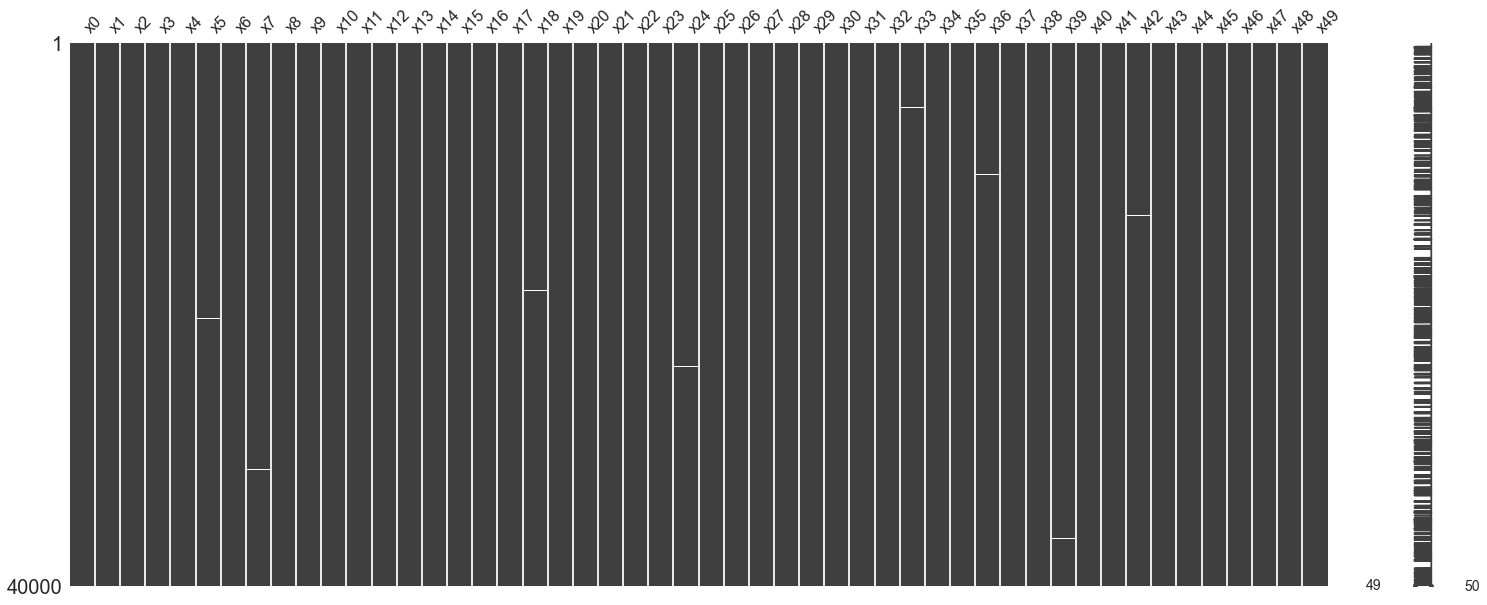

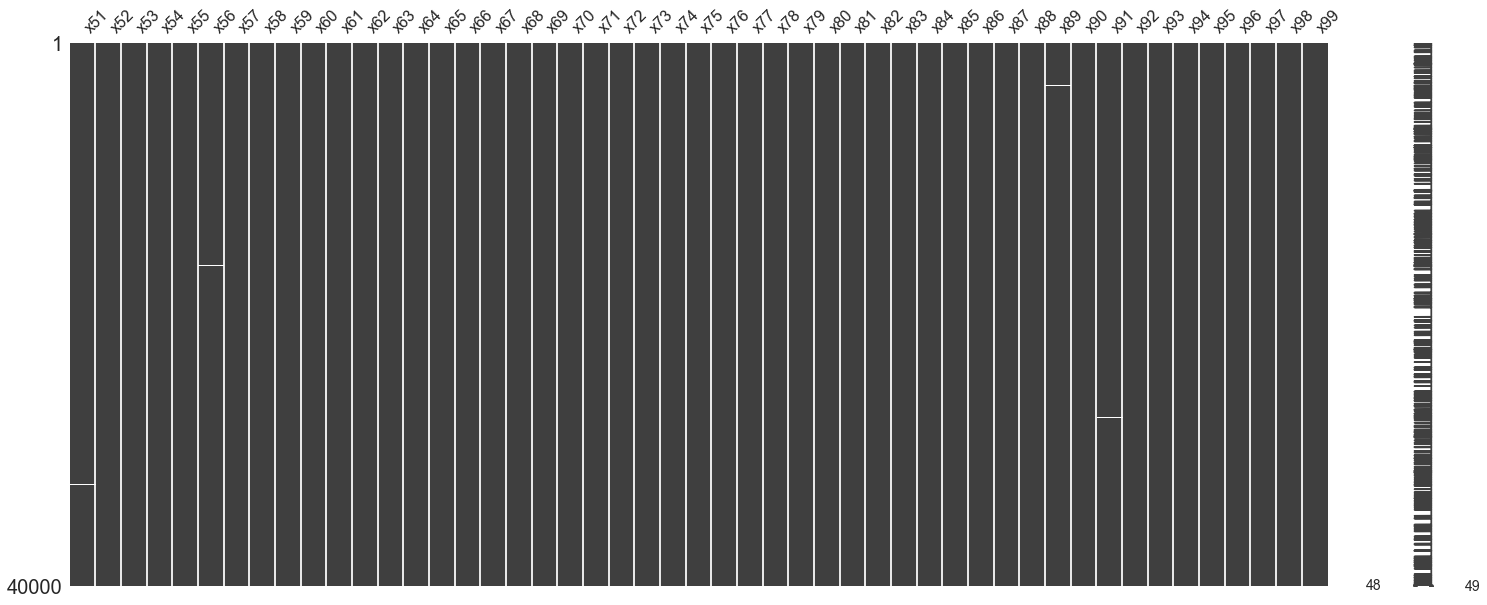

In [17]:
first_half = train.iloc[:,0:50]
msno.matrix(first_half)

second_half = train.iloc[:,51:100]
msno.matrix(second_half)

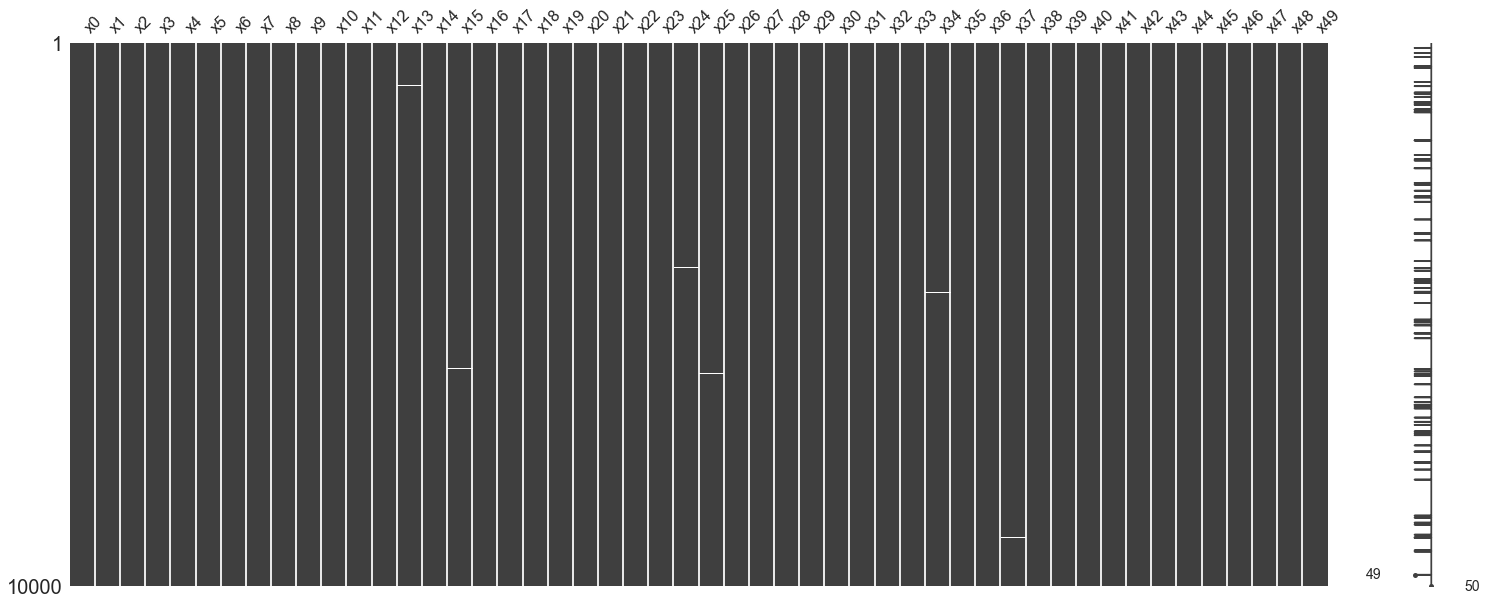

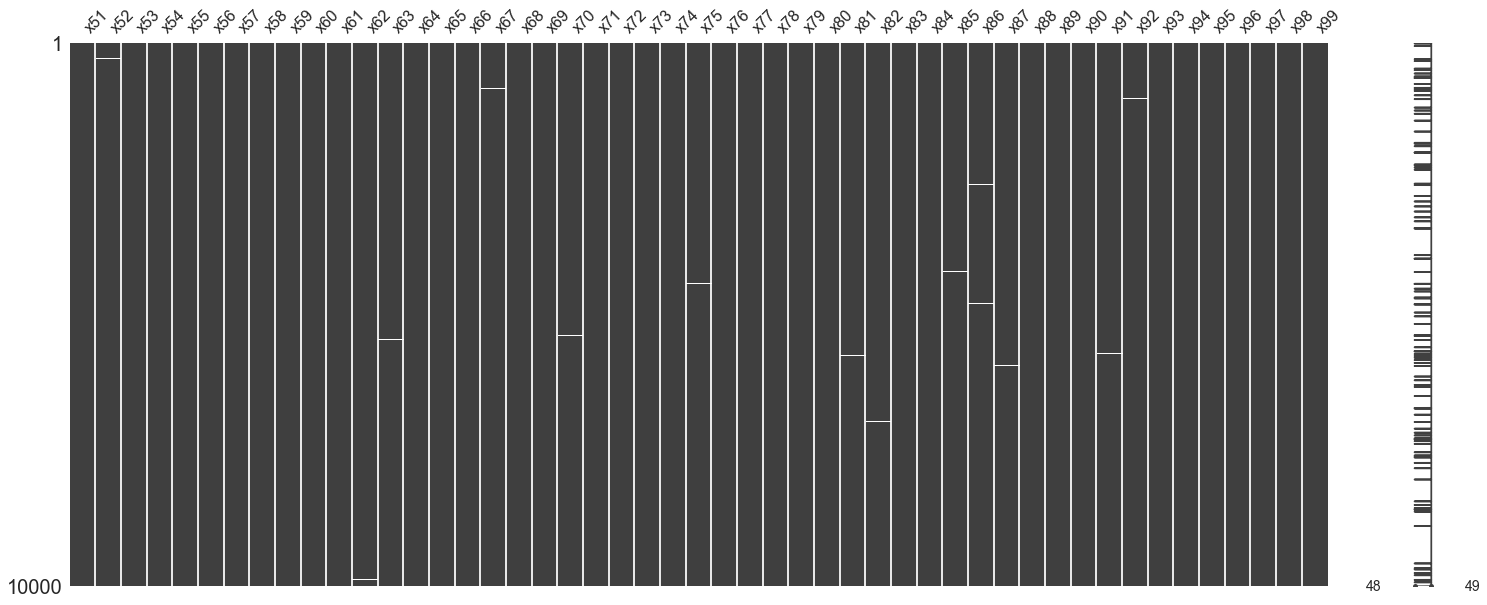

In [18]:
first_half = test.iloc[:,0:50]
msno.matrix(first_half)

second_half = test.iloc[:,51:100]
msno.matrix(second_half)

In [19]:
tmp = train.dropna()
print(f'train data loss from null removal: {100*len(tmp)/len(train):.2f}')
tmp = test.dropna()
print(f'test data loss from null removal: {100*len(tmp)/len(test):.2f}')

train data loss from null removal: 98.00
test data loss from null removal: 98.01


No patterns seen with the missing data. The missing appear to be missing at random (MAR) and removing the missing data would result in a 2% data loss for the train and test data sets.

#### Numeric Feature Observations
<a id="NumObs"></a>

<a href="#top">Back to Top</a>

Now let's visualize the distributions of the numeric data to determine whether average or median should be used for imputation. A function is used to also color code based on the classification so only the training data set is used. The training data represents 80% of the data split so distributions should be representative of the test data. The random pattern of the missing data support a random train/test split, too.

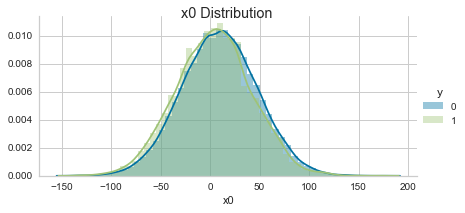

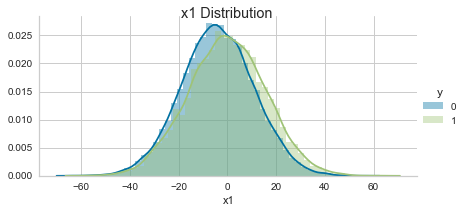

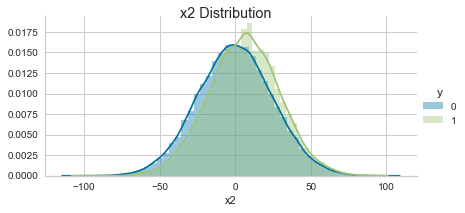

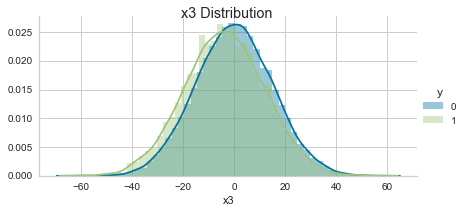

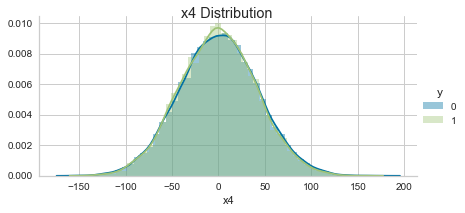

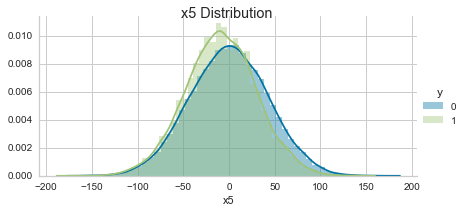

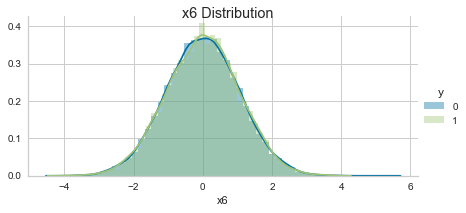

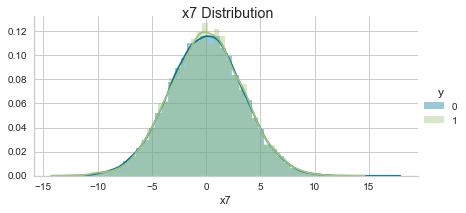

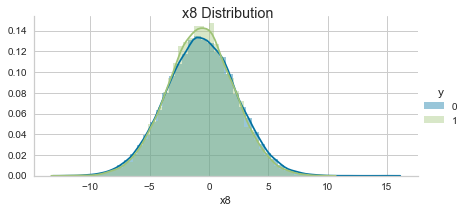

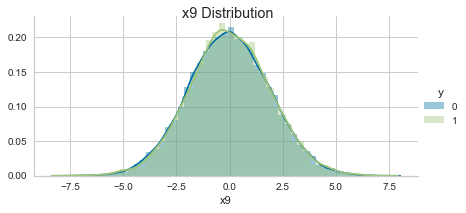

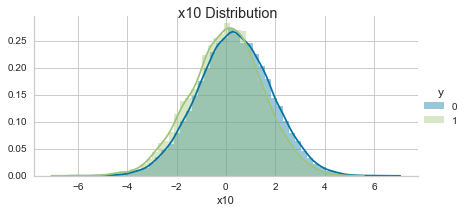

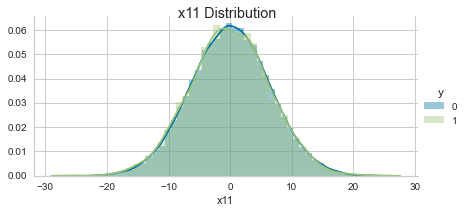

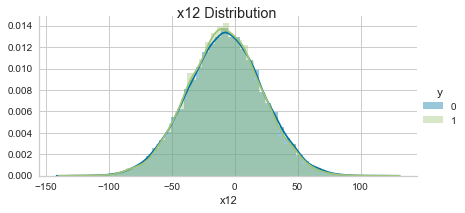

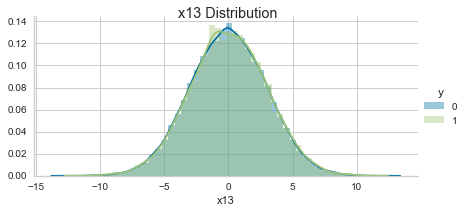

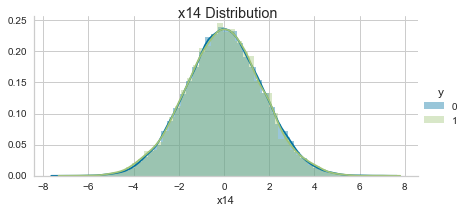

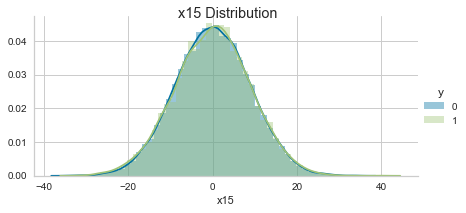

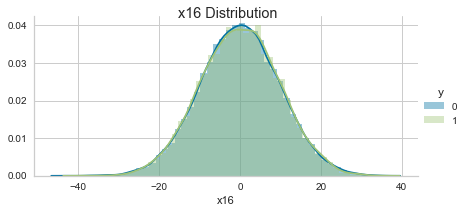

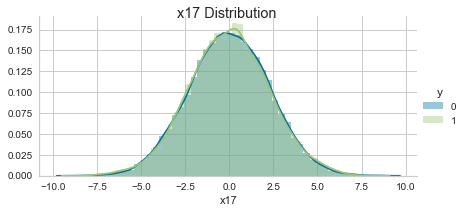

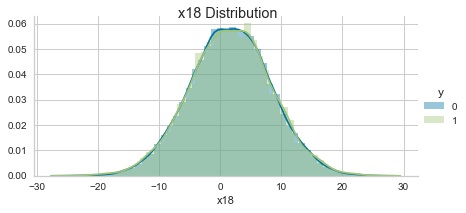

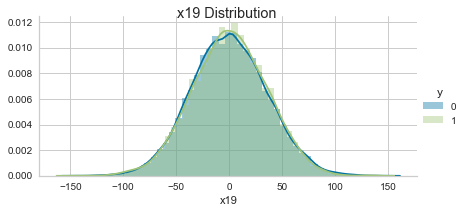

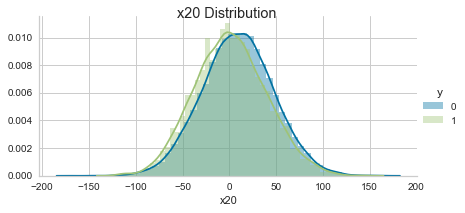

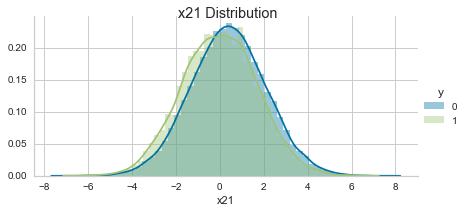

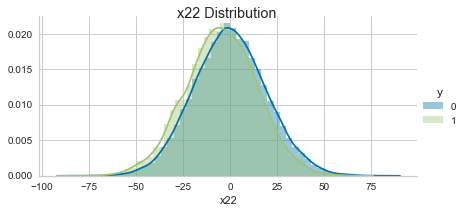

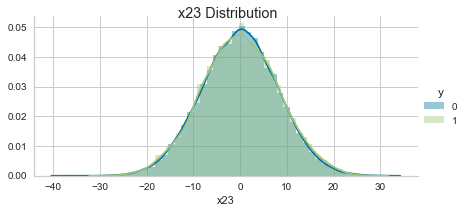

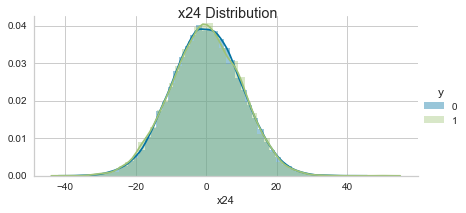

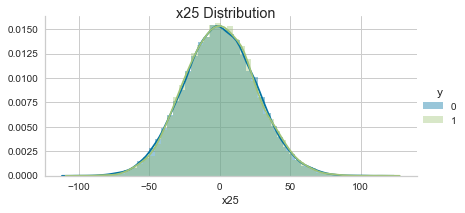

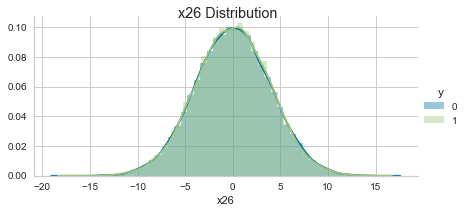

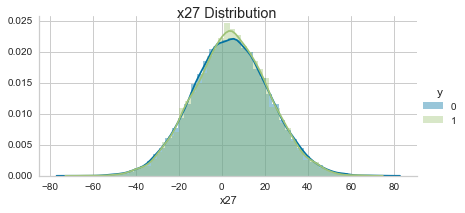

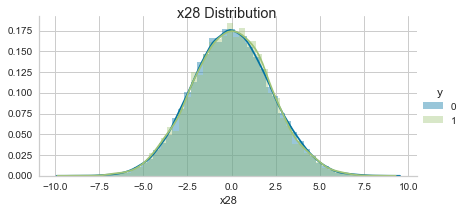

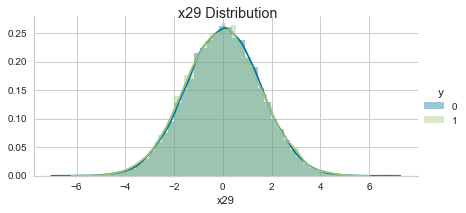

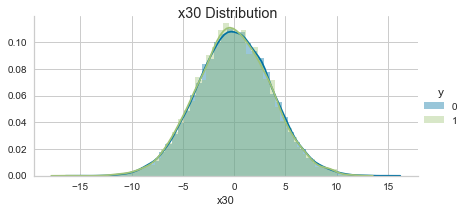

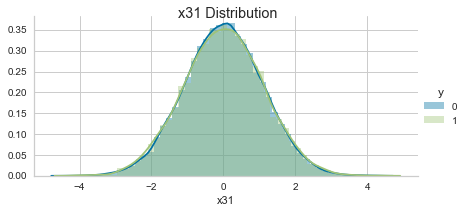

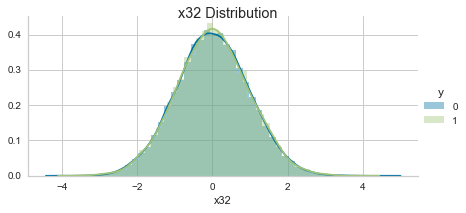

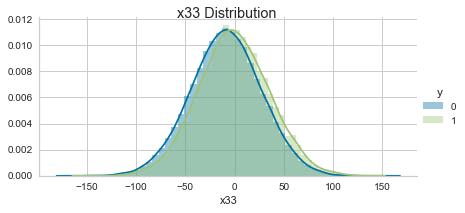

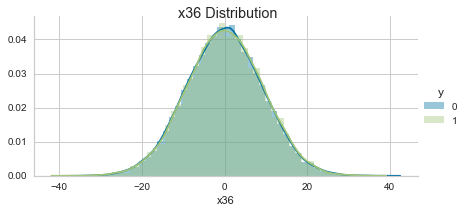

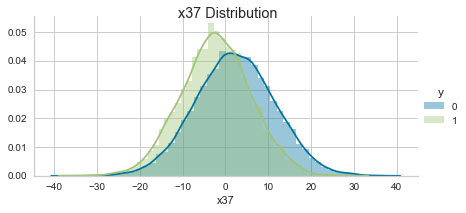

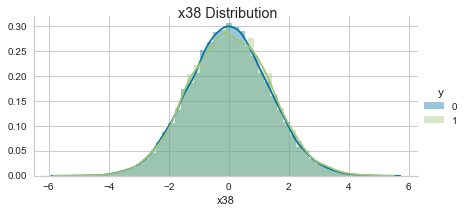

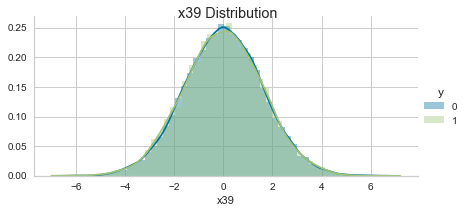

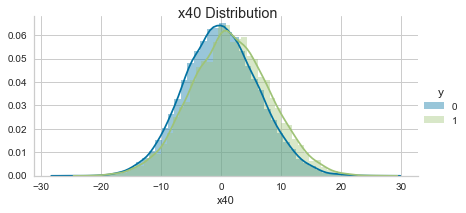

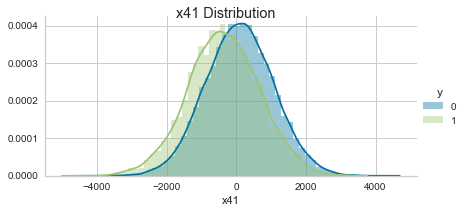

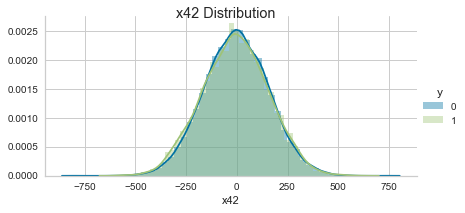

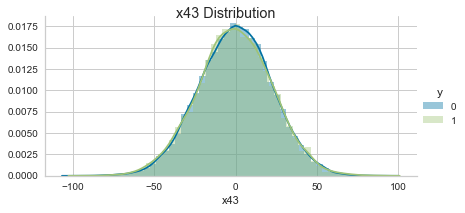

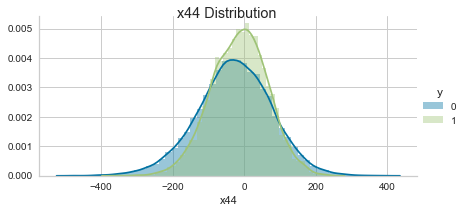

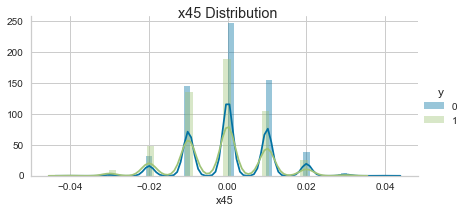

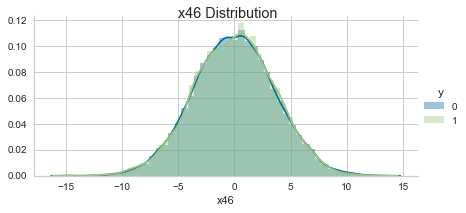

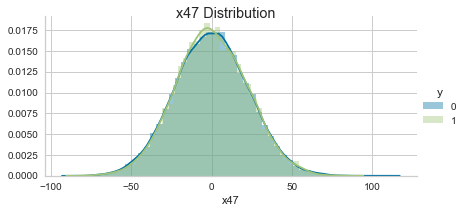

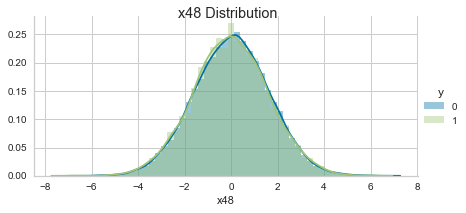

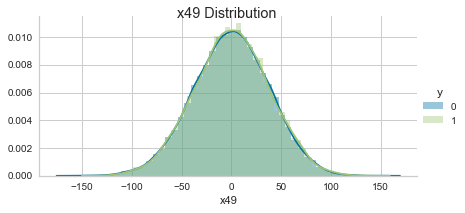

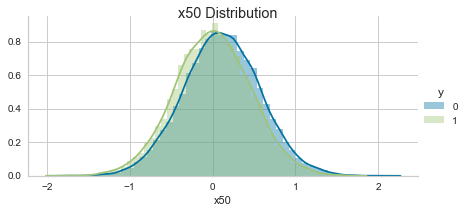

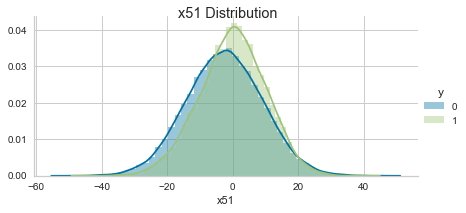

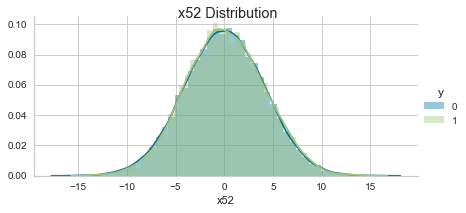

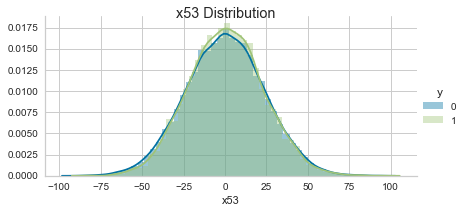

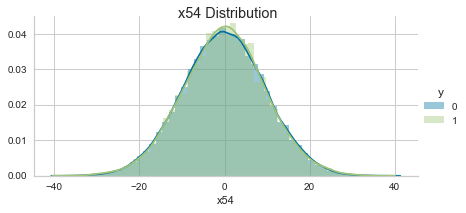

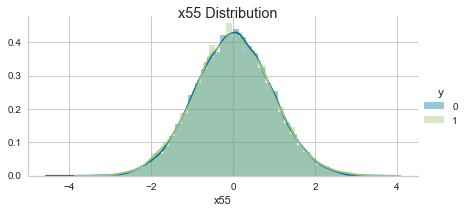

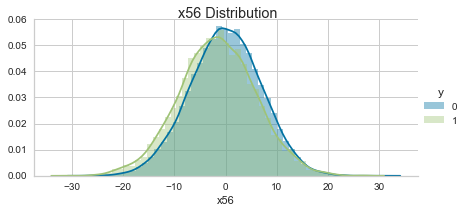

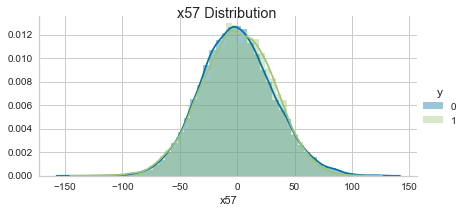

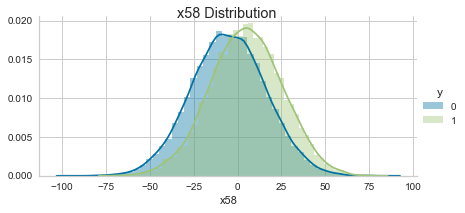

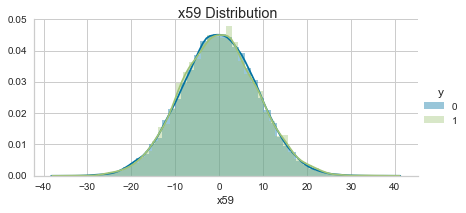

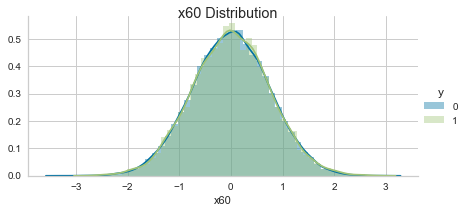

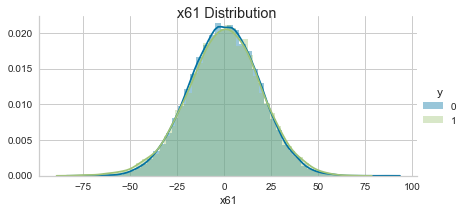

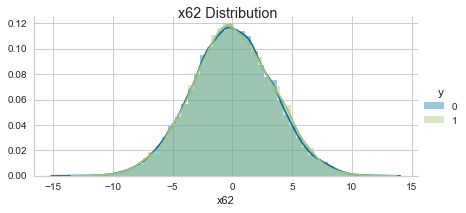

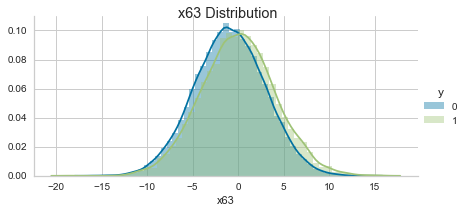

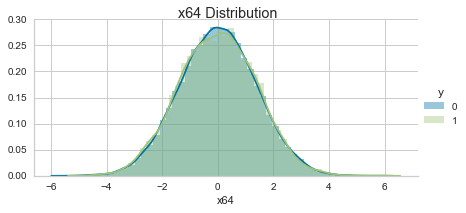

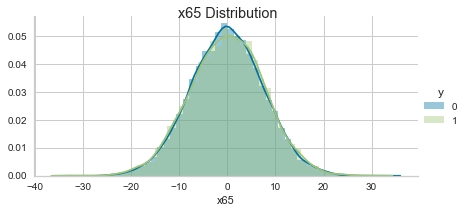

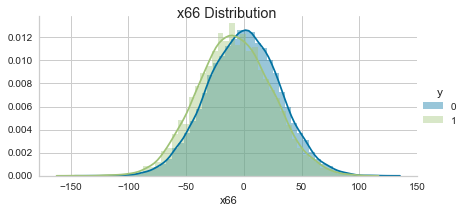

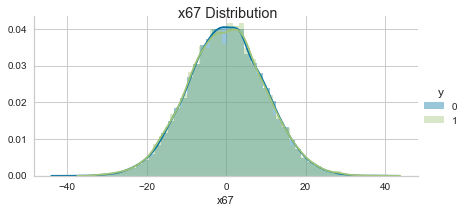

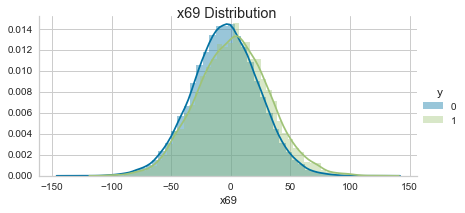

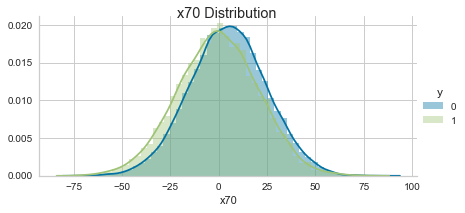

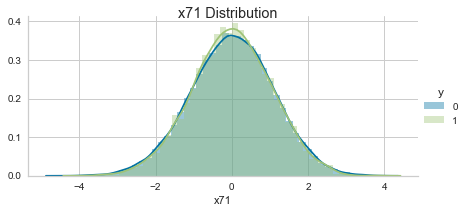

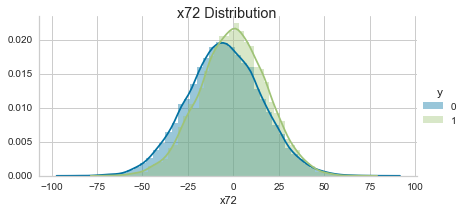

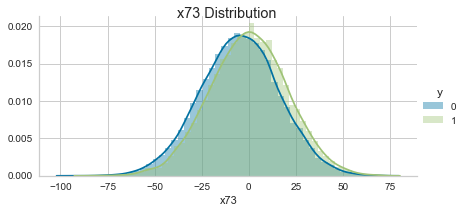

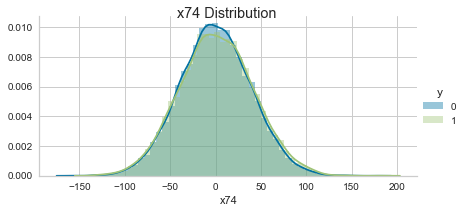

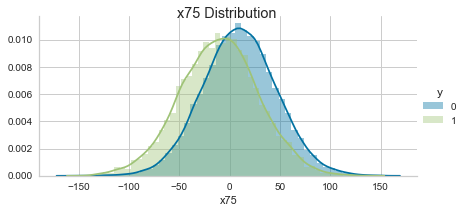

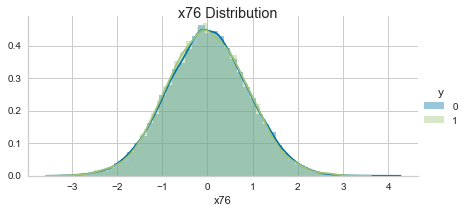

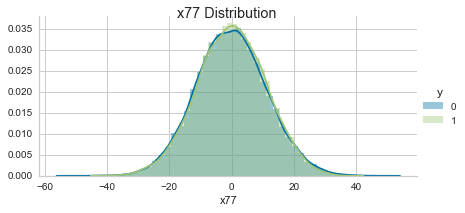

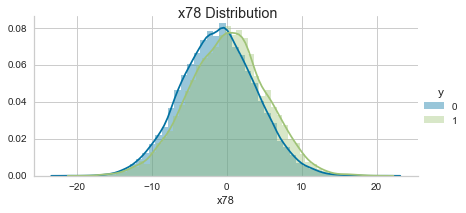

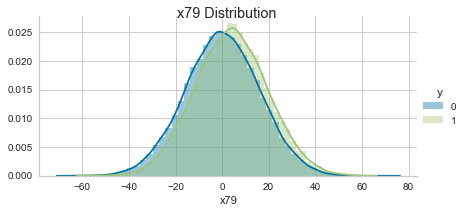

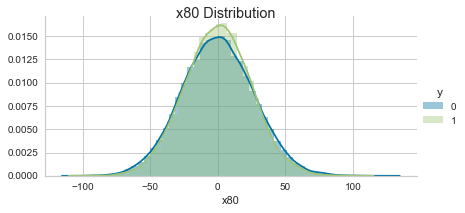

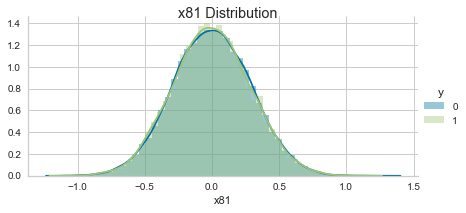

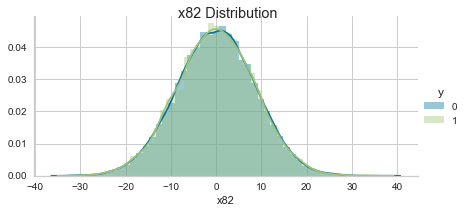

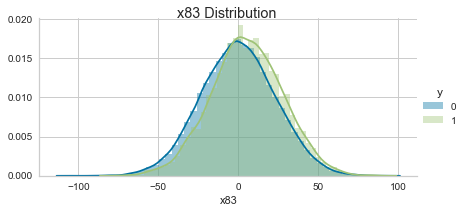

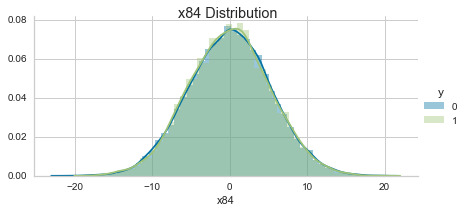

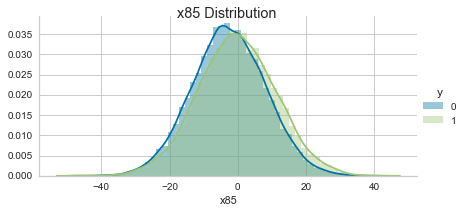

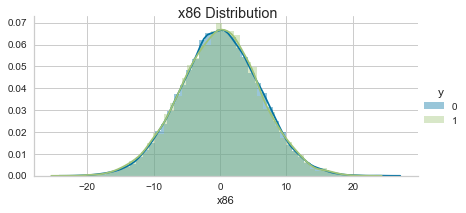

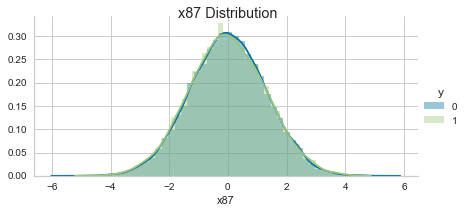

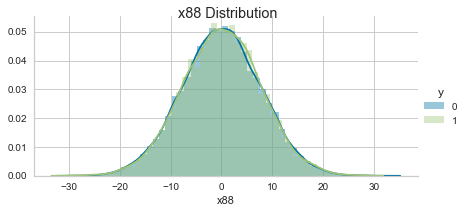

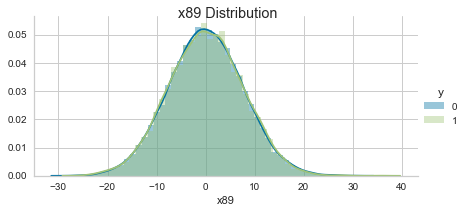

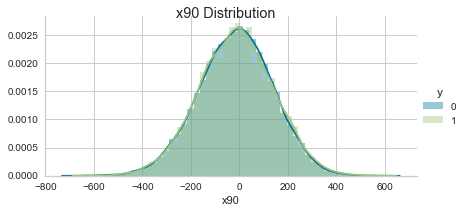

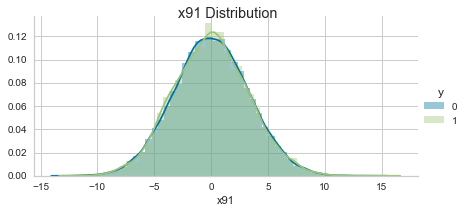

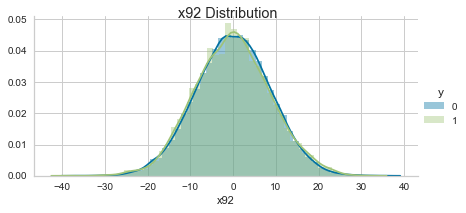

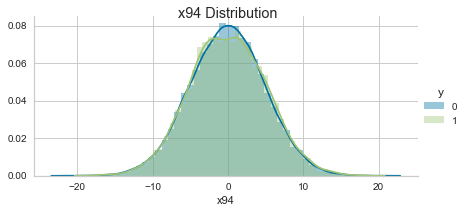

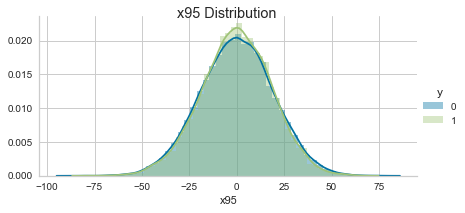

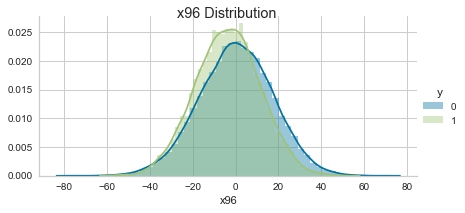

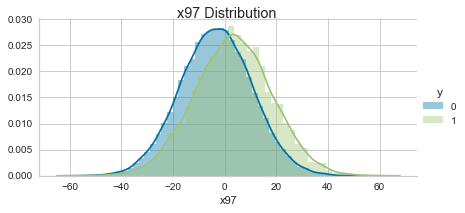

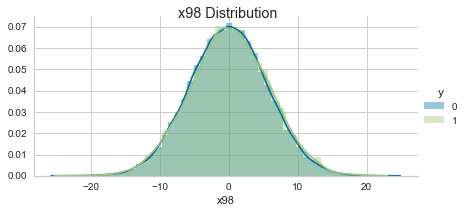

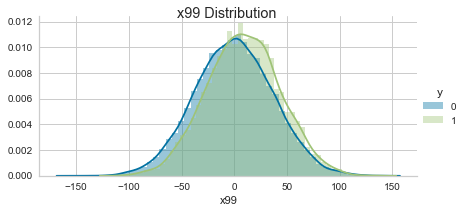

C:\Users\Steve\miniconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Steve\miniconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


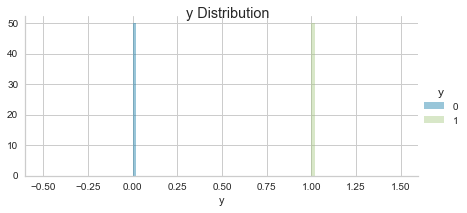

Wall time: 46.4 s


In [20]:
%%time
plt.rcParams['figure.max_open_warning']=100

for i in num_list[0:]:
    facet = sns.FacetGrid(train, hue='y',aspect=2)
    facet.map(sns.distplot,i)
    facet.add_legend()
    facet.fig.suptitle(''.join(map(str, list([i," Distribution"]))))
    plt.show()    

The distribution of the data are fairly uniform and class balanced. It appears we could use either average or median. 
There doesn't appear to be any concerning outliers either. Since the data is unknown, outliers should remain anyway unless justification deems otherwise.

#### Imputation
<a id="Impute"></a>

<a href="#top">Back to Top</a>

Since the missing values are random and despite only losing 2% of the data with a blanket removal of nulls, imputation is performed to preserve as much data as possible. Imputation with medians is used for continuous data and most frequent values (mode) for the categorical data. Imputation is performed separately on the train and test data sets to avoid data leakage.

In [21]:
# impute missing numeric values with median
train[num_list] = train[num_list].apply(lambda x: x.fillna(x.median()),axis=0) 

# impute missing numeric values with median
train[cat_list] = train[cat_list].apply(lambda x: x.fillna(x.value_counts().index[0])) 

# confirm missing values
train.isnull().sum() 

x0     0
x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
x11    0
x12    0
x13    0
x14    0
x15    0
x16    0
x17    0
x18    0
x19    0
x20    0
x21    0
x22    0
x23    0
x24    0
x25    0
x26    0
x27    0
x28    0
x29    0
x30    0
x31    0
x32    0
x33    0
x34    0
x35    0
x36    0
x37    0
x38    0
x39    0
x40    0
x41    0
x42    0
x43    0
x44    0
x45    0
x46    0
x47    0
x48    0
x49    0
x50    0
x51    0
x52    0
x53    0
x54    0
x55    0
x56    0
x57    0
x58    0
x59    0
x60    0
x61    0
x62    0
x63    0
x64    0
x65    0
x66    0
x67    0
x68    0
x69    0
x70    0
x71    0
x72    0
x73    0
x74    0
x75    0
x76    0
x77    0
x78    0
x79    0
x80    0
x81    0
x82    0
x83    0
x84    0
x85    0
x86    0
x87    0
x88    0
x89    0
x90    0
x91    0
x92    0
x93    0
x94    0
x95    0
x96    0
x97    0
x98    0
x99    0
y      0
dtype: int64

In [22]:
num_list.remove('y')

In [23]:
# impute missing numeric values with median
test[num_list] = test[num_list].apply(lambda x: x.fillna(x.median()),axis=0) 

# impute missing numeric values with median
test[cat_list] = test[cat_list].apply(lambda x: x.fillna(x.value_counts().index[0])) 

# confirm missing values
test.isnull().sum() 

x0     0
x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
x11    0
x12    0
x13    0
x14    0
x15    0
x16    0
x17    0
x18    0
x19    0
x20    0
x21    0
x22    0
x23    0
x24    0
x25    0
x26    0
x27    0
x28    0
x29    0
x30    0
x31    0
x32    0
x33    0
x34    0
x35    0
x36    0
x37    0
x38    0
x39    0
x40    0
x41    0
x42    0
x43    0
x44    0
x45    0
x46    0
x47    0
x48    0
x49    0
x50    0
x51    0
x52    0
x53    0
x54    0
x55    0
x56    0
x57    0
x58    0
x59    0
x60    0
x61    0
x62    0
x63    0
x64    0
x65    0
x66    0
x67    0
x68    0
x69    0
x70    0
x71    0
x72    0
x73    0
x74    0
x75    0
x76    0
x77    0
x78    0
x79    0
x80    0
x81    0
x82    0
x83    0
x84    0
x85    0
x86    0
x87    0
x88    0
x89    0
x90    0
x91    0
x92    0
x93    0
x94    0
x95    0
x96    0
x97    0
x98    0
x99    0
dtype: int64

There are no more missing data.

#### Check Label Balance
<a id="LabelBal"></a>

<a href="#top">Back to Top</a>

Let's check the balance of the label.

0.201175

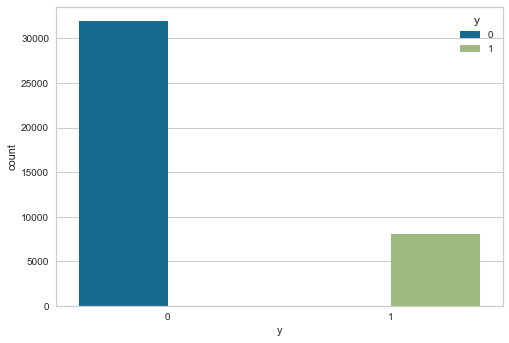

In [24]:
sns.countplot(x = 'y', hue = 'y', data = train )
train['y'].mean()

The label has an 80/20 balance for 0/1. Some consider this split on the bubble for whether under or oversampling should be performed. Although a training set is provided, a split of the train data or cross-validation will be used to determine performance. Models will be run with balanced and unbalanced data sets. Undersampling will be used in favor of creating simulated data. The modeling results dictate whether the label is balanced.

#### Review Categorical Data by Label Class
<a id="CatPlots"></a>

<a href="#top">Back to Top</a>

Review the label distribution by car, continent, month, and day of the week.

In [25]:
# print counts of each category class
for cat in train[cat_list]:
    print(train[cat].value_counts(dropna=False),'\n')

volkwagen    12579
toyota       10946
bmw           7304
honda         5129
tesla         2275
chrysler      1223
nissan         336
ford           165
mercedes        32
chevrolet       11
Name: x34, dtype: int64 

wed    20735
thu    17733
tue      929
fri      547
mon       56
Name: x35, dtype: int64 

jul    11097
jun     9279
aug     8155
may     4788
sep     3466
apr     1641
oct      926
mar      409
nov      156
feb       54
dec       18
jan       11
Name: x68, dtype: int64 

asia       35416
america     3136
europe      1448
Name: x93, dtype: int64 



Text(0.5, 1.0, 'Distribution by Car')

[Text(0, 0, 'bmw'),
 Text(0, 0, 'nissan'),
 Text(0, 0, 'honda'),
 Text(0, 0, 'toyota'),
 Text(0, 0, 'volkwagen'),
 Text(0, 0, 'tesla'),
 Text(0, 0, 'chrysler'),
 Text(0, 0, 'ford'),
 Text(0, 0, 'mercedes'),
 Text(0, 0, 'chevrolet')]

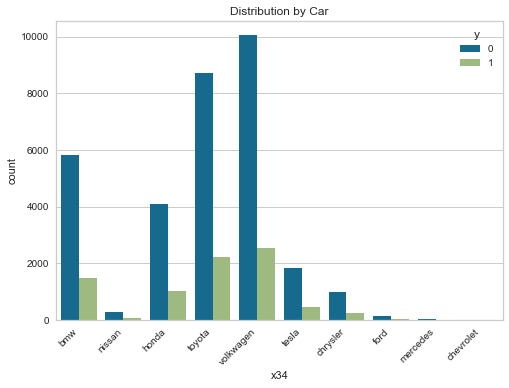

In [26]:
ax = plt.axes()
sns.countplot(x='x34', data=train, hue="y", ax = ax)
ax.set_title('Distribution by Car')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Most data comes from toyota, volkswagon, bmw, honda, and tesla. Most data for cars also align with class 0 for the label.

Text(0.5, 1.0, 'Distribution by Day of Week')

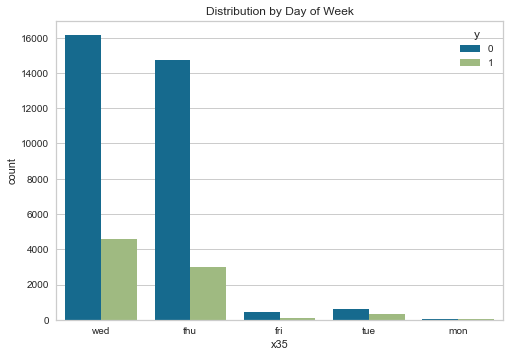

In [27]:
ax = plt.axes()
sns.countplot(x='x35', data=train, hue="y", ax = ax)
ax.set_title('Distribution by Day of Week')
plt.show()

Most data comes from wed and thur. Most data also align with class 0 for the label.

Text(0.5, 1.0, 'Distribution by Month')

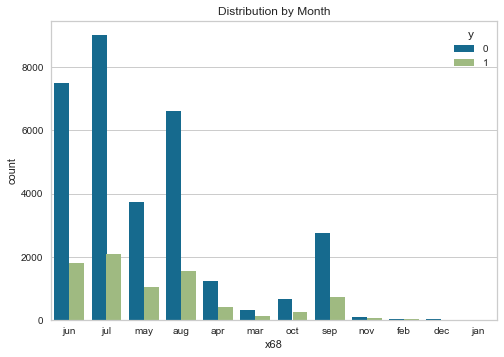

In [28]:
ax = plt.axes()
sns.countplot(x='x68', data=train, hue="y", ax = ax)
ax.set_title('Distribution by Month')
plt.show()

Most of the data falls between the warmer months of the year, May-September.

Text(0.5, 1.0, 'Distribution by Continent')

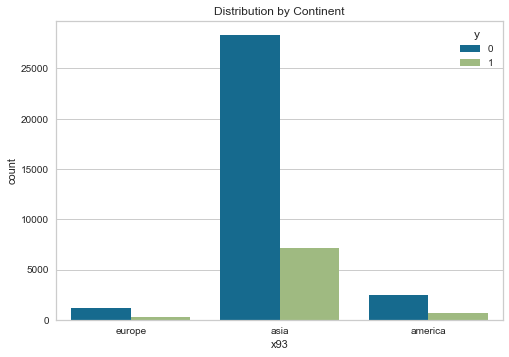

In [29]:
ax = plt.axes()
sns.countplot(x='x93', data=train, hue="y", ax = ax)
ax.set_title('Distribution by Continent')
plt.show()

Most of the data is from Asia, followed by America, then Europe.

### Feature Reduction

<a id="FR"></a>

<a href="#top">Back to Top</a>

#### Correlation

Let's look at a heatmap that shows correlation with numeric features.

Text(0.5, 1.0, 'Correlation Heatmap')

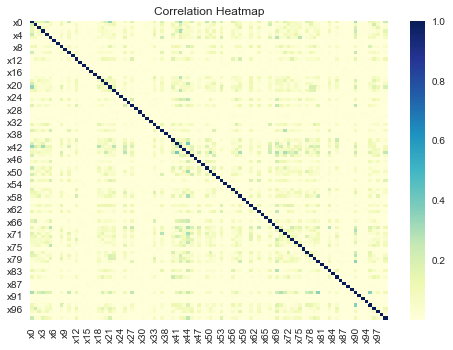

In [30]:
corr_matrix = train[num_list].corr(method = "spearman").abs()

ax = plt.axes()
sns.heatmap(corr_matrix, cmap="YlGnBu", ax = ax)
ax.set_title('Correlation Heatmap')
sns.set(rc={'figure.figsize':(16,12)}) # increase seaborn plot size
plt.show()

In [31]:
# Select upper triangle of matrix, both sides are equivalent
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
print(f'correlated feature (>= 0.7): {to_drop}')

correlated feature (>= 0.7): []


#### Check Correlation to the Target for Feature Reduction (data leakage)

In [32]:
# find correlations to target
corr_matrix = train.corr().abs()
corr_matrix['y'].sort_values(ascending=False).head(11)

y      1.000000
x75    0.210443
x37    0.195287
x58    0.186655
x97    0.184331
x41    0.181508
x70    0.104036
x1     0.101204
x99    0.098388
x22    0.097653
x3     0.096697
Name: y, dtype: float64

There is no highly correlated features to the target y.

#### DATA TRANSFORMATION
<a id="DataTrans"></a>

<a href="#top">Back to Top</a>

PCA will be performed on encoded and scaled data. First, days of the week and months are set as ordinal. For modeling, they will be considered continuous numeric data.

In [33]:
# convert days of week and months to ordinal numbers, will be treated as continuous variables
# performed manually so I can control the order and the effort is minimal
train['x35']=train['x35'].replace({'mon':'1','tue':'2','wed':'3','thu':'4','fri':'5'}).astype(int)
train['x68']=train['x68'].replace({'jan':'1','feb':'2','mar':'3','apr':'4','may':'5','jun':'6','jul':'7','aug':'8','sep':'9','oct':'10','nov':'11','dec':'12'}).astype(int)

test['x35']=test['x35'].replace({'mon':'1','tue':'2','wed':'3','thu':'4','fri':'5'}).astype(int)
test['x68']=test['x68'].replace({'jan':'1','feb':'2','mar':'3','apr':'4','may':'5','jun':'6','jul':'7','aug':'8','sep':'9','oct':'10','nov':'11','dec':'12'}).astype(int)

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 101 entries, x0 to y
dtypes: float64(96), int32(2), int64(1), object(2)
memory usage: 30.5+ MB


Re-adjust categorical and numeric lists.

In [35]:
cat_list.remove('x35')
cat_list.remove('x68')
print(f'new cateogorical features = {cat_list}')
num_list.append('x35')
num_list.append('x68')
print(f'new numerical features = {num_list}')

new cateogorical features = ['x34', 'x93']
new numerical features = ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90', 'x91', 'x92', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99', 'x35', 'x68']


#### One-Hot Encode Categorical Data

In [36]:
encoded_train = pd.get_dummies(data=train[cat_list], columns=cat_list, prefix_sep='_', drop_first=True)
encoded_test = pd.get_dummies(data=test[cat_list], columns=cat_list, prefix_sep='_', drop_first=True)

encoded_train.head()

,x34_chevrolet,x34_chrysler,x34_ford,x34_honda,x34_mercedes,x34_nissan,x34_tesla,x34_toyota,x34_volkwagen,x93_asia,x93_europe
0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,0,1,0


#### Scale Continuous Data 

In [37]:
mm_scaler = MinMaxScaler() # using MinMax scaler so data falls in the 0 to 1 range without distortion
scaled_train = mm_scaler.fit_transform(train[num_list])
scaled_train_df = pd.DataFrame(scaled_train, columns =train[num_list].columns)

scaled_test = mm_scaler.fit_transform(test[num_list])
scaled_test_df = pd.DataFrame(scaled_test, columns =test[num_list].columns)

scaled_train_df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x94,x95,x96,x97,x98,x99,x35,x68
0,0.474334,0.383187,0.532131,0.336254,0.549324,0.397276,0.429921,0.419873,0.482205,0.322413,0.422112,0.675789,0.634894,0.371479,0.607292,0.554855,0.489794,0.416985,0.741434,0.415817,0.425349,0.640703,0.331298,0.484539,0.440563,0.444492,0.439221,0.686692,0.457328,0.512001,0.447336,0.559674,0.467582,0.435051,0.562330,0.381506,0.604628,0.323746,0.495263,0.503441,0.480223,0.441305,0.506782,0.500,0.231913,0.439899,0.248248,0.415488,0.462108,0.511242,0.565314,0.436579,0.487152,0.365458,0.806935,0.503820,0.439815,0.407117,0.539314,0.448872,0.541580,0.427150,0.475756,0.329628,0.375835,0.450571,0.582999,0.515465,0.522872,0.380717,0.482476,0.497875,0.457183,0.463538,0.437532,0.668467,0.366750,0.423174,0.506338,0.595925,0.612458,0.594723,0.633350,0.527317,0.533953,0.454596,0.273593,0.409158,0.529843,0.586714,0.564116,0.529415,0.397017,0.367358,0.512806,0.580040,0.50,0.454545
1,0.278352,0.552124,0.461392,0.403372,0.529671,0.603721,0.449809,0.447606,0.419437,0.438988,0.594249,0.628163,0.507699,0.305251,0.407018,0.434359,0.296920,0.466891,0.475804,0.477207,0.642921,0.621869,0.475095,0.287420,0.393024,0.344519,0.580946,0.657420,0.432216,0.430803,0.602015,0.370303,0.329057,0.670433,0.461012,0.516335,0.356671,0.419132,0.655447,0.483584,0.338006,0.274402,0.541355,0.625,0.447400,0.520547,0.339425,0.603375,0.472235,0.419902,0.515904,0.268662,0.396194,0.557506,0.713894,0.456858,0.373503,0.365146,0.525855,0.457670,0.524749,0.398069,0.499451,0.561946,0.194883,0.523601,0.543835,0.611619,0.447846,0.581366,0.576331,0.473521,0.717360,0.308708,0.397920,0.638573,0.302223,0.212611,0.460925,0.525222,0.721977,0.460111,0.745056,0.479667,0.650855,0.323728,0.433686,0.481290,0.474226,0.464460,0.567902,0.718462,0.545728,0.573199,0.467292,0.507490,0.75,0.545455
2,0.655287,0.522432,0.575157,0.366547,0.609298,0.349463,0.464492,0.474405,0.554048,0.687451,0.732164,0.664410,0.445901,0.472117,0.300270,0.412873,0.725180,0.580836,0.678637,0.441052,0.553513,0.595111,0.442513,0.354464,0.281771,0.493398,0.549738,0.591162,0.516989,0.399832,0.561467,0.532388,0.545449,0.498950,0.530845,0.390963,0.588275,0.455182,0.508836,0.537188,0.441993,0.650871,0.614397,0.375,0.450482,0.476092,0.332483,0.448765,0.685023,0.430027,0.501252,0.625041,0.437809,0.512904,0.542861,0.401394,0.420380,0.517604,0.406402,0.609647,0.517849,0.567499,0.513340,0.509724,0.622463,0.707057,0.426495,0.447408,0.589341,0.493747,0.585553,0.485798,0.487242,0.285770,0.518554,0.587029,0.513557,0.637019,0.221628,0.470117,0.731666,0.546245,0.647069,0.616928,0.411089,0.364800,0.322667,0.469506,0.513048,0.684536,0.674839,0.583168,0.451144,0.552945,0.490781,0.252620,0.50,0.545455
3,0.354446,0.573459,0.472676,0.566201,0.459123,0.727815,0.344478,0.478052,0.355973,0.544937,0.423490,0.516076,0.623648,0.475016,0.497519,0.515339,0.388451,0.655475,0.631443,0.750059,0.686141,0.371003,0.410192,0.625989,0.489156,0.392330,0.406771,0.514298,0.437517,0.614791,0.367569,0.417964,0.273133,0.454717,0.441943,0.557607,0.410973,0.620001,0.407511,0.523868,0.602913,0.587437,0.680733,0.750,0.675506,0.229805,0.513638,0.600982,0.530832,0.601418,0.610161,0.480698,0.313404,0.581707,0.347925,0.582268,0.425980,0.491253,0.780011,0.545405,0.465500,0.529015,0.617086,0.556664,0.703116,0.415624,0.504737,0.411541,0.385777,0.610062,0.655897,0.581090,0.521458,0.338072,0.387824,0.517062,0.528571,0.669506,0.290443,0.439339,0.527269,0.586230,0.343115,0.403771,0.494620,0.549539,0.358533,0.657213,0.343041,0.562949,0.389564,0.404655,0.623866,0.410601,0.538230,0.567831,0.75,0.363636
4,0.696096,0.747486,0.367639,0.345969,0.196273,0.358002,0.369148,0.418725,0.481585,0.408242,0.522319,0.630533

In [38]:
train_scaled_encoded = pd.concat([scaled_train_df, encoded_train], axis = 1)
train_scaled_encoded['y'] = train['y']

# create data set of unscaled continuous features and one-hot encoded features
train_encoded = pd.concat([train[num_list], encoded_train],axis=1)
test_encoded = pd.concat([test[num_list], encoded_test],axis=1)

test_scaled_encoded = pd.concat([scaled_test_df, encoded_test], axis = 1)

X_df = pd.concat([scaled_train_df, encoded_train], axis = 1)
X_df.head()
X_df.shape

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x94,x95,x96,x97,x98,x99,x35,x68,x34_chevrolet,x34_chrysler,x34_ford,x34_honda,x34_mercedes,x34_nissan,x34_tesla,x34_toyota,x34_volkwagen,x93_asia,x93_europe
0,0.474334,0.383187,0.532131,0.336254,0.549324,0.397276,0.429921,0.419873,0.482205,0.322413,0.422112,0.675789,0.634894,0.371479,0.607292,0.554855,0.489794,0.416985,0.741434,0.415817,0.425349,0.640703,0.331298,0.484539,0.440563,0.444492,0.439221,0.686692,0.457328,0.512001,0.447336,0.559674,0.467582,0.435051,0.562330,0.381506,0.604628,0.323746,0.495263,0.503441,0.480223,0.441305,0.506782,0.500,0.231913,0.439899,0.248248,0.415488,0.462108,0.511242,0.565314,0.436579,0.487152,0.365458,0.806935,0.503820,0.439815,0.407117,0.539314,0.448872,0.541580,0.427150,0.475756,0.329628,0.375835,0.450571,0.582999,0.515465,0.522872,0.380717,0.482476,0.497875,0.457183,0.463538,0.437532,0.668467,0.366750,0.423174,0.506338,0.595925,0.612458,0.594723,0.633350,0.527317,0.533953,0.454596,0.273593,0.409158,0.529843,0.586714,0.564116,0.529415,0.397017,0.367358,0.512806,0.580040,0.50,0.454545,0,0,0,0,0,0,0,0,0,0,1
1,0.278352,0.552124,0.461392,0.403372,0.529671,0.603721,0.449809,0.447606,0.419437,0.438988,0.594249,0.628163,0.507699,0.305251,0.407018,0.434359,0.296920,0.466891,0.475804,0.477207,0.642921,0.621869,0.475095,0.287420,0.393024,0.344519,0.580946,0.657420,0.432216,0.430803,0.602015,0.370303,0.329057,0.670433,0.461012,0.516335,0.356671,0.419132,0.655447,0.483584,0.338006,0.274402,0.541355,0.625,0.447400,0.520547,0.339425,0.603375,0.472235,0.419902,0.515904,0.268662,0.396194,0.557506,0.713894,0.456858,0.373503,0.365146,0.525855,0.457670,0.524749,0.398069,0.499451,0.561946,0.194883,0.523601,0.543835,0.611619,0.447846,0.581366,0.576331,0.473521,0.717360,0.308708,0.397920,0.638573,0.302223,0.212611,0.460925,0.525222,0.721977,0.460111,0.745056,0.479667,0.650855,0.323728,0.433686,0.481290,0.474226,0.464460,0.567902,0.718462,0.545728,0.573199,0.467292,0.507490,0.75,0.545455,0,0,0,0,0,1,0,0,0,1,0
2,0.655287,0.522432,0.575157,0.366547,0.609298,0.349463,0.464492,0.474405,0.554048,0.687451,0.732164,0.664410,0.445901,0.472117,0.300270,0.412873,0.725180,0.580836,0.678637,0.441052,0.553513,0.595111,0.442513,0.354464,0.281771,0.493398,0.549738,0.591162,0.516989,0.399832,0.561467,0.532388,0.545449,0.498950,0.530845,0.390963,0.588275,0.455182,0.508836,0.537188,0.441993,0.650871,0.614397,0.375,0.450482,0.476092,0.332483,0.448765,0.685023,0.430027,0.501252,0.625041,0.437809,0.512904,0.542861,0.401394,0.420380,0.517604,0.406402,0.609647,0.517849,0.567499,0.513340,0.509724,0.622463,0.707057,0.426495,0.447408,0.589341,0.493747,0.585553,0.485798,0.487242,0.285770,0.518554,0.587029,0.513557,0.637019,0.221628,0.470117,0.731666,0.546245,0.647069,0.616928,0.411089,0.364800,0.322667,0.469506,0.513048,0.684536,0.674839,0.583168,0.451144,0.552945,0.490781,0.252620,0.50,0.545455,0,0,0,1,0,0,0,0,0,1,0
3,0.354446,0.573459,0.472676,0.566201,0.459123,0.727815,0.344478,0.478052,0.355973,0.544937,0.423490,0.516076,0.623648,0.475016,0.497519,0.515339,0.388451,0.655475,0.631443,0.750059,0.686141,0.371003,0.410192,0.625989,0.489156,0.392330,0.406771,0.514298,0.437517,0.614791,0.367569,0.417964,0.273133,0.454717,0.441943,0.557607,0.410973,0.620001,0.407511,0.523868,0.602913,0.587437,0.680733,0.750,0.675506,0.229805,0.513638,0.600982,0.530832,0.601418,0.610161,0.480698,0.313404,0.581707,0.347925,0.582268,0.425980,0.491253,0.780011,0.545405,0.465500,0.529015,0.617086,0.556664,0.703116,0.415624,0.504737,0.411541,0.385777,0.610062,0.655897,0.581090,0.521458,0.338072,0.387824,0.517062,0.528571,0.669506,0.290443,0.439339,0.527269,0.586230,0.343115,0.403771,0.494620,0.549539,0.358533,0.657213,0.34

(40000, 109)

#### Check Low Variance for Feature Reduction Opportunity on Scaled & Encoded Data

In [39]:
sel = feature_selection.VarianceThreshold()
train_scaled_encoded.shape
train_variance = sel.fit_transform(train_scaled_encoded)
train_variance.shape

(40000, 110)

(40000, 110)

No features exhibit low variation for removal from the data set.

#### Check Correlation to the Target for Feature Reduction (data leakage)

In [40]:
# find correlations to target
corr_matrix = train_scaled_encoded.corr().abs()
corr_matrix['y'].sort_values(ascending=False).head(11)

y      1.000000
x75    0.210443
x37    0.195287
x58    0.186655
x97    0.184331
x41    0.181508
x70    0.104036
x1     0.101204
x99    0.098388
x22    0.097653
x3     0.096697
Name: y, dtype: float64

The are no highly correlated features to the label **y** with the scaled and encoded data set.

#### PCA Analysis
<a id="PCA"></a>

<a href="#top">Back to Top</a>

In [41]:
pca = PCA()
pca_X_train = pca.fit_transform(X_df)
pca_X_test = pca.fit_transform(X_df)

pca_X_df = pd.DataFrame(data=pca_X_train)
pca_variance = pca.explained_variance_

pca_X_df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108
39995,-0.700755,-0.260894,-0.120813,-0.076174,0.029767,0.004343,0.360491,0.081591,0.027911,0.205126,-0.046225,-0.046753,-0.213367,0.272997,0.009326,-0.110384,0.184033,-0.007496,-0.154083,-0.041874,0.271694,0.199203,-0.345678,0.050748,-0.161746,0.240845,-0.142064,0.112663,-0.170927,-0.026001,0.189638,-0.132179,-0.269247,0.123946,-0.143693,0.229172,-0.037800,0.071957,-0.139026,0.233901,-0.051571,-0.057022,0.001235,0.029374,0.183910,-0.040690,0.124296,-0.052486,0.047190,0.120848,-0.026280,-0.066776,-0.076585,0.021200,-0.086002,0.190030,0.177624,-0.027891,-0.079541,-0.101236,0.272612,-0.026165,0.139340,-0.205461,-0.169283,-0.080445,-0.072837,0.000328,0.031899,0.161688,0.013753,0.011871,0.075063,-0.032987,-0.027415,-0.114463,-0.053774,0.299554,-0.073174,-0.098794,-0.053951,-0.014141,-0.040011,-0.035211,-0.056873,-0.027264,0.072797,-0.077120,0.056514,0.030320,-0.012268,-0.160764,0.020397,-0.006294,0.046084,0.000625,-0.041716,0.040222,0.002725,0.003929,-0.014803,-0.037804,-0.001955,-0.000578,-0.002683,-0.011050,0.006414,0.000046,-0.000215
39996,0.087212,0.865238,-0.121676,-0.405158,0.050663,-0.125893,-0.204393,0.390510,0.017373,0.088713,-0.195373,-0.003462,-0.042192,-0.128219,0.215433,-0.190374,0.208092,0.008554,-0.022308,0.049095,-0.025249,0.169082,0.005436,-0.227462,0.068217,-0.194010,-0.196093,0.031100,-0.028588,0.158240,0.162991,0.110270,-0.020509,-0.096481,-0.156976,-0.155185,0.087019,0.214369,-0.122833,-0.190831,0.044927,-0.231677,-0.094524,-0.092934,0.060882,0.014065,0.049831,0.140866,-0.043419,0.053835,-0.018417,0.084194,-0.028229,0.000889,0.126353,0.207732,0.392341,-0.072791,-0.036523,0.258346,-0.022311,-0.128201,0.168148,0.018743,0.105696,0.109453,0.192889,-0.220822,0.025082,0.098234,-0.062867,0.061599,-0.138060,-0.136622,-0.012900,0.095010,0.146088,0.080095,0.040294,0.006599,-0.021382,-0.107433,0.051469,0.042838,-0.096297,-0.066351,-0.042744,0.056493,-0.150596,-0.081798,0.015049,-0.053777,0.069607,0.006122,0.032336,0.019614,0.085972,-0.077135,0.007533,0.045160,-0.032833,-0.079555,0.000098,0.001203,-0.006498,-0.014242,0.004395,0.000242,-0.000328
39997,-0.702767,-0.256414,0.809425,-0.087252,0.035843,-0.035888,0.082998,-0.016180,0.017847,-0.025994,-0.199057,-0.172152,-0.176421,0.138761,0.201216,-0.087310,0.099057,0.070932,0.035530,-0.332744,0.008547,0.037290,0.065284,0.047947,-0.044275,-0.013218,0.274521,-0.195782,0.062517,-0.163806,0.247298,-0.013187,0.122056,-0.184585,-0.097279,-0.024673,-0.150424,-0.243320,0.045929,-0.149408,0.040431,0.104910,0.035972,-0.053090,-0.206410,0.066130,0.016888,-0.033231,0.146695,-0.097903,-0.030296,-0.109533,-0.015575,-0.053572,0.126454,0.207881,0.032540,0.024523,0.351512,-0.051350,0.210821,-0.002828,-0.120725,0.099632,-0.107400,-0.022576,0.068014,0.197717,-0.081748,0.070678,0.084535,0.038013,0.015486,0.106832,-0.086474,0.005440,-0.005566,-0.181765,-0.108171,0.075310,0.087347,0.027390,0.023294,0.126239,0.007680,0.007927,-0.017873,0.032853,-0.014403,-0.044390,-0.000016,-0.021584,-0.142278,-0.036101,-0.113096,-0.038624,-0.126580,0.021710,-0.001105,-0.033304,-0.103638,0.005425,0.000487,0.001478,-0.010253,0.009097,0.001471,0.000041,0.000140
39998,0.706718,-0.356523,0.806524,-0.107452,0.151914,-0.071383,-0.395672,0.199524,0.158383,0.258445,-0.139896,0.192395,-0.144472,-0.002101,0.255507,0.077866,0.101173,0.082262,0.137509,-0.310217,-0.036605,-0.058159,-0.075861,-0.344023,-0.012593,-0.020307,-0.060484,0.209792,0.176626,-0.028104,-0.071112,-0.003431,0.034974,0.020618,-0.055854,-0.126403,0.039356,0.051472,-0.082147,0.142502,-0.182416,-0.109913,0.139052,0.137371,0.175692,0.019866,0.013878,0.078435,0.158869,0.133621,-0.181717,0.027228,0.140943,-0.034830,0.047130,0.315859,0.058024,-0.

In [42]:
#print(f'Explained variation per principal component: {pca.explained_variance_ratio_}')
pca_count = 80
var_sum = 0
for i in range(pca_count):
    #print(f'{i} = {pca.explained_variance_ratio_[i]}')
    var_sum += pca.explained_variance_ratio_[i]
print(f'sum of {pca_count} principal components = {100*var_sum:.2f}%')

sum of 80 principal components = 93.22%


<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Number of Components')

Text(0, 0.5, 'Variance (%)')

Text(0.5, 1.0, 'Explained Variance')

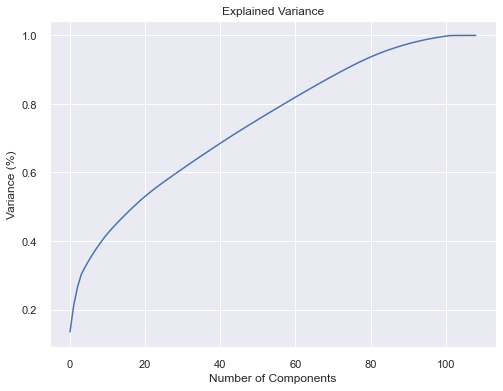

In [43]:
#Fitting the PCA algorithm with our Data
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

The PCA analysis doesn't show a significant reduction of components. It takes 90 principal components to capture 97.25% of the variation and 80 principal components to capture ~93% of the variation. 

In [44]:
pca = PCA(n_components=80)
pca_X_train = pca.fit_transform(X_df)

# 80/20 training/test split with stratification since label is unbalanced 
X_train, X_test, y_train, y_test = train_test_split(pca_X_train, train['y'], test_size=0.20, stratify=train['y'], random_state=17)

___
<u>DATA SETS</u>

train = spelling & data type corrected, imputed

train_scaled_encoded = like train but scaled & encoded

pca_X_train = train feature PCA reduced
___

### Modeling
<a id="Modeling"></a>

<a href="#top">Back to Top</a>
### LogReg Model - PCA Features
<a id="LogReg"></a>

Uses data that has been cleaned, imputed, encoded, scaled, label is NOT re-balanced

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000123E6E73BE0>,
       classes=None, encoder=None, force_model=False, is_fitted='auto',
       macro=False, micro=False, model=None, per_class=True)

0.842375

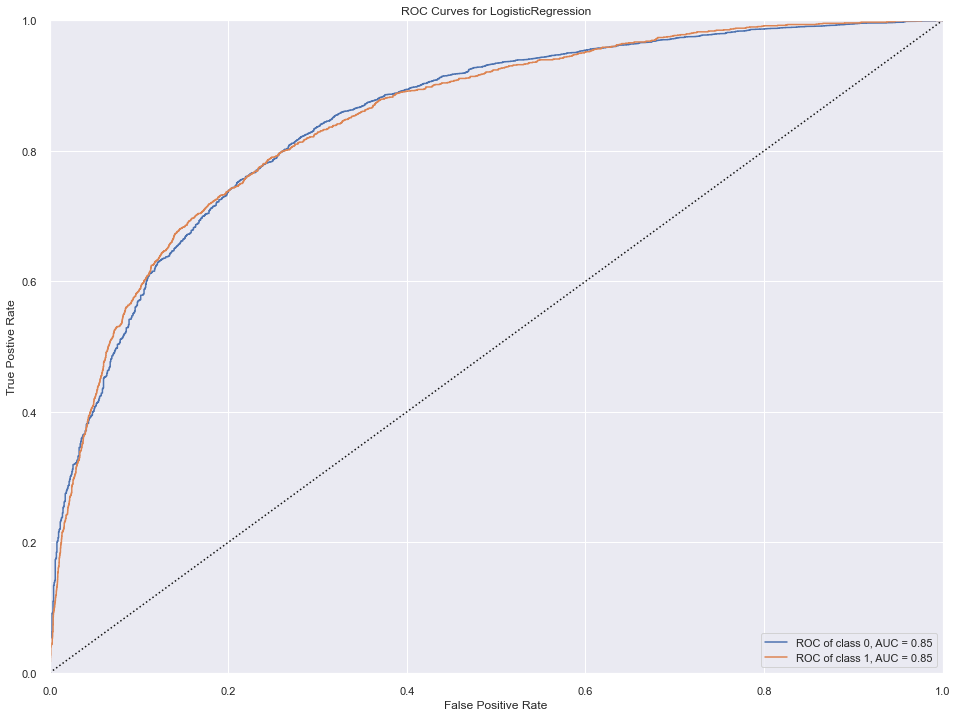

In [46]:
# 80/20 training/test split with stratification since label is unbalanced 
X_train, X_test, y_train, y_test = train_test_split(pca_X_train, train['y'], test_size=0.20, stratify=train['y'], random_state=17)

# instantiate the model
logreg = LogisticRegression(solver='liblinear')

viz = ROCAUC(logreg, micro=False, macro=False)                
#viz = ClassificationReport(logreg) 
viz.fit(X_train, y_train) # fit the model
viz.score(X_test, y_test)       # Evaluate the model on the test data
viz.show()                          # Show the results

Using PCA on a baseline logistic regression model produced an AUC = 0.85.

### Baseline LogReg Model

Uses data that has been cleaned, imputed, encoded, scaled, label is NOT re-balanced

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001E533B2CC18>,
       classes=None, encoder=None, force_model=False, is_fitted='auto',
       macro=False, micro=False, model=None, per_class=True)

0.888625

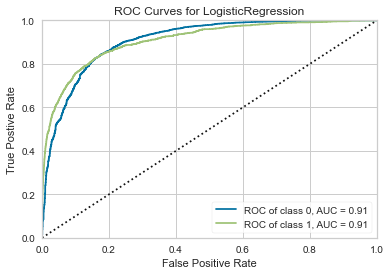

In [273]:
# 80/20 training/test split with stratification since label is unbalanced 
X_train, X_test, y_train, y_test = train_test_split(X_df, train['y'], test_size=0.20, stratify=train['y'], random_state=17)

# instantiate the model
logreg = LogisticRegression(solver='liblinear')

viz = ROCAUC(logreg, micro=False, macro=False)                
#viz = ClassificationReport(logreg) 
viz.fit(X_train, y_train) # fit the model
viz.score(X_test, y_test)       # Evaluate the model on the test data
viz.show()                          # Show the results

Using the features transformed with scaling and encoding produced an AUC = 0.91. This is better than the PCA version.

### Baseline LogReg Model - Label Rebalanced

Uses data that has been cleaned, imputed, encoded, scaled, label re-balanced.

SMOTE uses a k_neighbors algorithm to choose which records to sample for downsampling the majority class. Downsampling the majority class to match that of the minority class was chosen as preference over fabricating too much data with oversampling.

In [274]:
# 80/20 training/test split with stratification since label is unbalanced 
X_train, X_test, y_train, y_test = train_test_split(X_df, train['y'], test_size=0.20, stratify=train['y'], random_state=17)

# Rebalance the label
nm = NearMiss(random_state=7)

X_train_nm, y_train_nm = nm.fit_sample(X_train, y_train)
np.bincount(y_train_nm)

array([6438, 6438], dtype=int64)

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001E533B87E10>,
       classes=None, encoder=None, force_model=False, is_fitted='auto',
       macro=False, micro=False, model=None, per_class=True)

0.80375

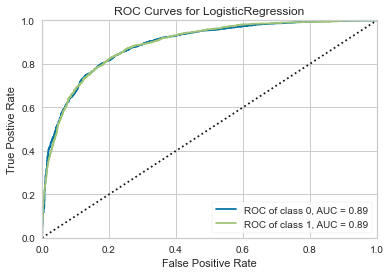

In [275]:
# instantiate the model
logreg = LogisticRegression(solver='liblinear')

viz = ROCAUC(logreg, micro=False, macro=False)              
#viz = ClassificationReport(logreg) 
viz.fit(X_train_nm, y_train_nm) # fit the model
viz.score(X_test, y_test)       # Evaluate the model on the test data
viz.show()                          # Show the results

Using the features transformed with scaling and encoding and undersampling the label produced an AUC = 0.89. This is not an improvement over the non-undersampled version.

### LogReg Grid Search

In [170]:
np.logspace(0, 4, 10)

array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04])

In [73]:
# 80/20 training/test split with stratification since label is unbalanced 
X_train, X_test, y_train, y_test = train_test_split(X_df, train['y'], test_size=0.20, stratify=train['y'], random_state=17)

# instantiate the model
logreg = LogisticRegression(solver='liblinear')

# set Grid Parameters
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)

lr_grid = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)

In [75]:
%%time
best_logreg = lr_grid.fit(X_train, y_train)

Wall time: 27min 16s


In [78]:
print('Best Penalty:', lr_grid.best_estimator_.get_params()['penalty'])
print('Best C:', lr_grid.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 59.94842503189409


#### Narrow C Search Range to Finetune

In [86]:
penalty = ['l2']
C = np.linspace(20, 160, 15)
hyperparameters = dict(C=C, penalty=penalty)

lr_grid = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)

In [87]:
%%time
best_logreg = lr_grid.fit(X_train, y_train)

Wall time: 2min 9s


In [88]:
print('Best Penalty:', lr_grid.best_estimator_.get_params()['penalty'])
print('Best C:', lr_grid.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 80.0


### Best LogReg Model

Uses data that has been cleaned, imputed, encoded, scaled, label is NOT re-balanced. Use l2 penalty and C = 80.

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000015597B35B38>,
       classes=None, encoder=None, force_model=False, is_fitted='auto',
       macro=False, micro=False, model=None, per_class=True)

0.887125

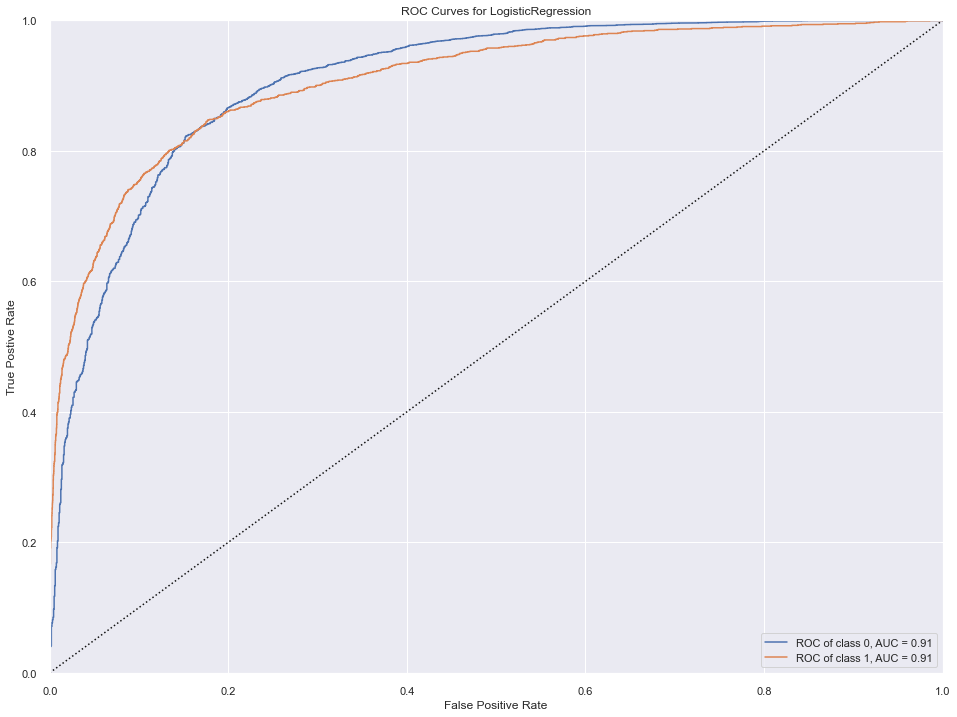

In [49]:
# 80/20 training/test split with stratification since label is unbalanced 
X_train, X_test, y_train, y_test = train_test_split(X_df, train['y'], test_size=0.20, stratify=train['y'], random_state=17)

# instantiate the model
best_logreg = LogisticRegression(solver='liblinear', C=80.0, penalty='l2')

viz = ROCAUC(best_logreg, micro=False, macro=False)                
#viz = ClassificationReport(logreg) 
viz.fit(X_train, y_train) # fit the model
viz.score(X_test, y_test) # Evaluate the model on the test data
viz.show()                # Show the results

### Produce Logistic Regression Predictions

In [50]:
lr_pred = best_logreg.predict(test_scaled_encoded)
lr_prob = best_logreg.predict_proba(test_scaled_encoded)
print(f'predicted value count = {len(lr_prob)}')

# write to file
lr_prob_df = pd.DataFrame(lr_prob[:,1])
lr_prob_df.to_csv('results1.csv', header=False, index=False) 

predicted value count = 10000


___

### Baseline Random Forest Model
<a id="rf"></a>

<a href="#top">Back to Top</a>

Uses data that has been cleaned, imputed, and encoded.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001D8481AAF28>,
       classes=None, encoder=None, force_model=False, is_fitted='auto',
       macro=False, micro=False, model=None, per_class=True)

0.8595

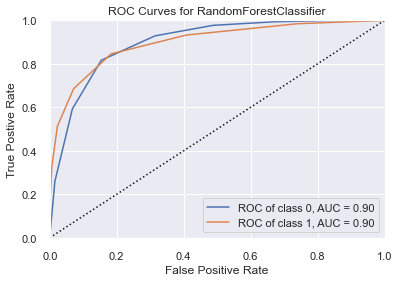

In [160]:
# 80/20 training/test split with stratification since label is unbalanced 
X_train, X_test, y_train, y_test = train_test_split(train_encoded, train['y'], test_size=0.20, stratify=train['y'], random_state=17)

# instantiate the model
rf = RandomForestClassifier(random_state=17)

viz = ROCAUC(rf, micro=False, macro=False)                
#viz = ClassificationReport(logreg) 
viz.fit(X_train, y_train) # fit the model
viz.score(X_test, y_test)       # Evaluate the model on the test data
viz.show()                          # Show the results

### RF Grid Search

In [161]:
# 80/20 training/test split with stratification since label is unbalanced 
X_train, X_test, y_train, y_test = train_test_split(train_encoded, train['y'], test_size=0.20, stratify=train['y'], random_state=17)

# instantiate the model
rf = RandomForestClassifier(random_state=17)

# set Grid Parameters
rf_hyperparams = {'n_estimators': [200, 500, 1000],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [3, 4, 5, 10],
               'criterion' :['gini', 'entropy']
          }

rf_grid = GridSearchCV(rf, rf_hyperparams, cv=5, verbose=0)

In [162]:
%%time
best_rf = rf_grid.fit(X_train, y_train) 

Wall time: 6h 13min 41s


In [163]:
best_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 200}

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000015597B45C50>,
       classes=None, encoder=None, force_model=False, is_fitted='auto',
       macro=False, micro=False, model=None, per_class=True)

0.837625

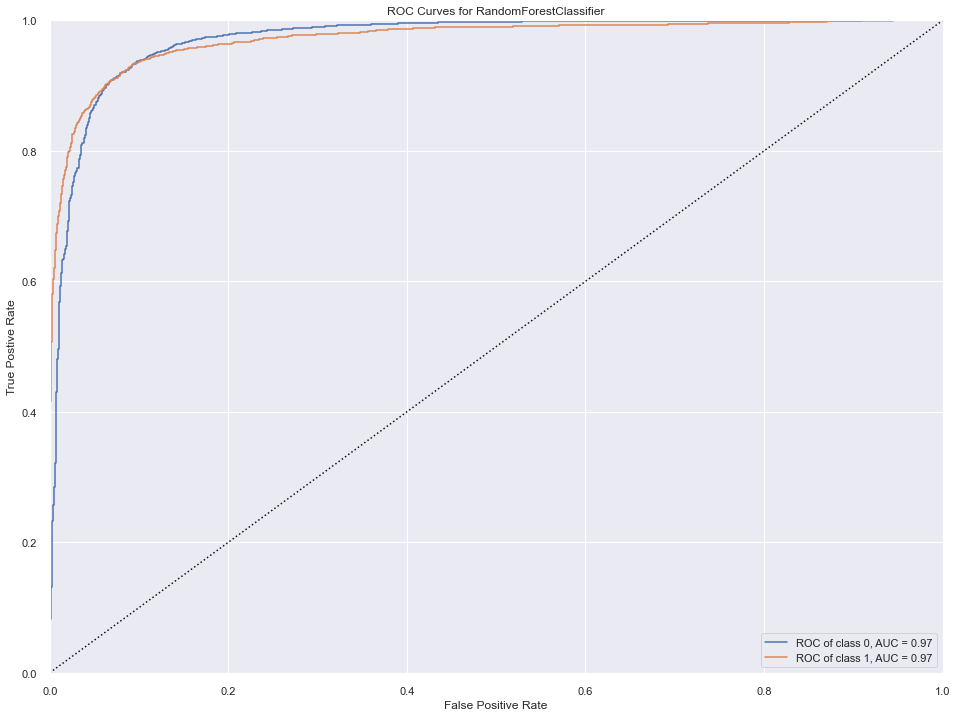

In [53]:
# 80/20 training/test split with stratification since label is unbalanced 
X_train, X_test, y_train, y_test = train_test_split(train_encoded, train['y'], test_size=0.20, stratify=train['y'], random_state=17)

best_rf = RandomForestClassifier(random_state = 17,
                            max_depth =10,
                            max_features = 'auto',
                            n_estimators=200)
viz = ROCAUC(best_rf, micro=False, macro=False)                
viz.fit(X_train, y_train) # fit the model
viz.score(X_test, y_test)       # Evaluate the model on the test data
viz.show()                          # Show the results

### Produce Logistic Regression Predictions

In [54]:
rf_pred = best_rf.predict(test_encoded )
rf_prob = best_rf.predict_proba(test_encoded)
print(f'predicted value count = {len(rf_prob)}')

# write to file
rf_prob_df = pd.DataFrame(rf_prob[:,1])
rf_prob_df.to_csv('results2.csv', header=False, index=False) 

predicted value count = 10000


#### Recommendation

The random forest model is expected to perform best out of the two models. An 80/20 split of the train data set was used to train and validate the models. The best logistic regression model produced an AUC = 0.91 and the best random forest model produced an AUC = 0.97. 

#### Future Work
It is preferred to understand the business case, problem, and goal of the model. Our target metric for this case study was AUC but the business case may deem recall as more important and models can be tuned to a specific metric. For example, if knowing whether you have the coronavirus is key, recall would be the preferred metric. The F1 score could have been used in lieu of AUC since it is a single metric that combines precision and recall using the harmonic mean and sometimes multiple metrics are considered as opposed to just one.
If the business case is understood, it can open doors to improving the data by adding new features that make sense. If the features are known, additional feature engineering may be performed, too. There are also many options for modeling as well. I believe the random forest model performed well but if it hadn’t or if it doesn’t meet expectations with fresh data, there are opportunities for improvement besides cycling back through data cleaning and feature engineering. The model tuning itself has some opportunity for improvement since two parameters were at their grid search boundaries. Other models and techniques include support vector machines (SVM), Naïve Bayes, k nearest neighbors (KNN), gradient boost machines (GBM), Neural Networks, and applying various ensemble techniques.